# LV segmentation on ES & ED cardiac images

In [ ]:
!python -c 'import tensorflow as tf; print(tf.__version__)'

2.8.2


In [ ]:
!pip install pycmap
!pip install tensorflow-addons==0.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.7 MB/s 
     |████████████████████████████████| 223 kB 15.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.7 MB/s 


## Set up & auxiliary functions

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import losses
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import sys
import pycmap
import numpy as np
from tensorflow.python.util import compat

In [ ]:
import tensorflow_addons as tfa

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/ColabNotebooks/Datasets/cardiac_images_colab/') #add path to drive
%cd /content/drive/MyDrive/ColabNotebooks/Datasets/cardiac_images_colab

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/Datasets/cardiac_images_colab


In [ ]:
def parse_image(img_path: str) -> dict:

    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    mask_path = tf.strings.regex_replace(img_path, "images", "annotations_binary")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)


    return {'image': image, 'segmentation_mask': mask}

In [ ]:
!ls /content/drive/MyDrive/ColabNotebooks/Datasets/cardiac_images_colab/

annotations	    weights00000013.h5	weights00000030.h5  weights00000047.h5
annotations_binary  weights00000014.h5	weights00000031.h5  weights00000048.h5
final.png	    weights00000015.h5	weights00000032.h5  weights00000049.h5
images		    weights00000016.h5	weights00000033.h5  weights00000050.h5
my_model.h5	    weights00000017.h5	weights00000034.h5  weights00000051.h5
weights00000001.h5  weights00000018.h5	weights00000035.h5  weights00000052.h5
weights00000002.h5  weights00000019.h5	weights00000036.h5  weights00000053.h5
weights00000003.h5  weights00000020.h5	weights00000037.h5  weights00000054.h5
weights00000004.h5  weights00000021.h5	weights00000038.h5  weights00000055.h5
weights00000005.h5  weights00000022.h5	weights00000039.h5  weights00000056.h5
weights00000006.h5  weights00000023.h5	weights00000040.h5  weights00000057.h5
weights00000007.h5  weights00000024.h5	weights00000041.h5  weights00000058.h5
weights00000008.h5  weights00000025.h5	weights00000042.h5  weights00000059.h5
weights0

#### Loading training and test images

In [ ]:
train_imgs_ED = tf.data.Dataset.list_files(
    "/content/drive/MyDrive/ColabNotebooks/Datasets/cardiac_images_colab/images/training/ED/*.jpg"
    )

test_imgs_ED = tf.data.Dataset.list_files(
    "/content/drive/MyDrive/ColabNotebooks/Datasets/cardiac_images_colab/images/testing/ED/*.jpg"
    )

train_imgs_ES = tf.data.Dataset.list_files(
    "/content/drive/MyDrive/ColabNotebooks/Datasets/cardiac_images_colab/images/training/ES/*.jpg"
    )

test_imgs_ES = tf.data.Dataset.list_files(
    "/content/drive/MyDrive/ColabNotebooks/Datasets/cardiac_images_colab/images/testing/ES/*.jpg"
    )

In [ ]:
# decode images and link them with their corresponding masks returning a dictionary of train and test  elements

train_set_ED = train_imgs_ED.map(parse_image)
test_set_ED = test_imgs_ED.map(parse_image)
train_set_ES = train_imgs_ED.map(parse_image)
test_set_ES = test_imgs_ED.map(parse_image)

train = train_set_ES.concatenate(train_set_ED)
test = test_set_ES.concatenate(test_set_ED)

# train = tf.data.Dataset.zip((train_set_ED, train_set_ES))
# test = tf.data.Dataset.zip((test_set_ED, test_set_ES))

print(train)
print(test)

dataset = {"train": train  , "test": test}

<ConcatenateDataset element_spec={'image': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None)}>
<ConcatenateDataset element_spec={'image': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None)}>


In [ ]:
def memory_efficient_shuffle(dataset_A, dataset_B):
  shuffle_rounds = 4
  tmp_start = 0
  batch_each_class = 2500
  final_shuffle_ds = None

  for i in range(shuffle_rounds):
    tmp_start = batch_each_class * i
    tmp_dataset_A = dataset_A.skip(tmp_start).take(batch_each_class)
    tmp_no_dataset_A = dataset_B.skip(tmp_start).take(batch_each_class)
    both_portions = tmp_dataset_A.concatenate(tmp_no_dataset_A)
    shuffled_portion_ds = both_portions.shuffle(5000)
    
    final_shuffled_ds = shuffled_portion_ds if final_shuffle_ds == None else final_shuffle_ds.concatenate(shuffled_portion_ds)
  return final_shuffled_ds

In [ ]:
num_training_ED_examples = 0
num_test_ED_examples = 0
num_training_ES_examples = 0
num_test_ES_examples = 0

num_training_examples = 0
num_test_examples = 0


for example in train_imgs_ED:
    num_training_ED_examples += 1

for example in test_imgs_ED:
    num_test_ED_examples += 1

for example in train_imgs_ES:
    num_training_ES_examples += 1

for example in test_imgs_ES:
    num_test_ES_examples += 1

num_training_examples = num_training_ED_examples + num_training_ES_examples
num_test_examples = num_test_ED_examples + num_test_ES_examples


print('number of training images (ED) = ', num_training_ED_examples)
print('number of testing images (ED) = ', num_test_ED_examples)
print('number of training images (ES) = ', num_training_ES_examples)
print('number of testing images (ES) = ', num_test_ES_examples)
print("\n")
print("number of training examples (all) = ", num_training_examples)
print("number of test examples (all) = ", num_test_examples)

number of training images (ED) =  299
number of testing images (ED) =  150
number of training images (ES) =  300
number of testing images (ES) =  150


number of training examples (all) =  599
number of test examples (all) =  300


normalization

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #input_mask -= 1
  return input_image, input_mask

augmentation

In [ ]:
def augment(input_image, input_mask):
          
    # flipping random horizontal or vertical
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_up_down(input_image)
        input_mask = tf.image.flip_up_down(input_mask)

    # rotation in 15° steps
    rot_factor = tf.cast(tf.random.uniform(shape=[], maxval=12, dtype=tf.int32), tf.float32)
    angle = np.pi/96*rot_factor
    input_image = tfa.image.rotate(input_image, angle)
    input_mask = tfa.image.rotate(input_mask, angle)

    return input_image, input_mask

We create two functions to preprocess the training and test datasets with a slight difference between the two – we only perform image augmentation on the training dataset.

In [ ]:
def load_image_train(datapoint):
  SIZE = 512
  input_image = tf.image.resize(datapoint['image'], (SIZE, SIZE))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (SIZE, SIZE))
  input_image, input_mask = augment(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  SIZE = 512
  input_image = tf.image.resize(datapoint['image'], (SIZE, SIZE))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (SIZE, SIZE))
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
train_dataset = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(load_image_test)

In [ ]:
BUFFER_SIZE = 100
BATCH_SIZE = 8

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

validation_batches = test_dataset.take(96).batch(BATCH_SIZE)
test_batches = test_dataset.skip(100).take(54).batch(BATCH_SIZE)

In [ ]:
train_batches = train_batches.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
count = 0
for i in validation_batches:
   count +=1
print("number of validation batches:", count)

number of validation batches: 12


In [ ]:
count = 0
for i in test_batches:
   count +=1
print("number of test batches:", count)

number of test batches: 7


In [ ]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
    #plt.colorbar()
  plt.show()

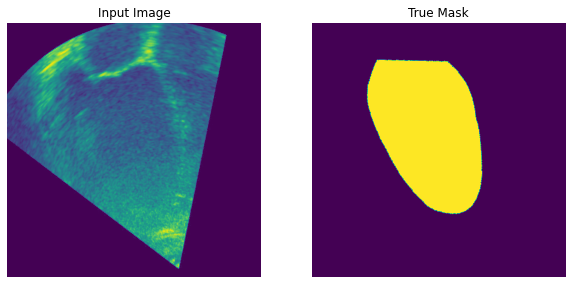

In [ ]:
for image, mask in train_dataset.take(1):
   sample_image, sample_mask = image, mask
   display([sample_image, sample_mask])

## U-Net

<img src='https://drive.google.com/uc?id=1HyCV6yXBEme6LdEiWU7k3vGs-Nh4allR' />

In [ ]:
def conv_block(input_tensor, num_filters):
  # Conv2D then batch normalization and ReLU activation
  encoder = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = tf.keras.layers.BatchNormalization()(encoder)
  encoder = tf.keras.layers.Activation('relu')(encoder)
  # Conv2D then batch normalization and ReLU activation
  encoder = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = tf.keras.layers.BatchNormalization()(encoder)
  encoder = tf.keras.layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  # upsample
  decoder = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  # concatenate
  decoder = tf.keras.layers.concatenate([concat_tensor, decoder], axis=-1)
  # batch normalization
  decoder = tf.keras.layers.BatchNormalization()(decoder)
  # ReLU activation
  decoder = tf.keras.layers.Activation('relu')(decoder)
  # Conv2D twice with batch normalization and ReLU activation
  decoder = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = tf.keras.layers.BatchNormalization()(decoder)
  decoder = tf.keras.layers.Activation('relu')(decoder)
  decoder = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = tf.keras.layers.BatchNormalization()(decoder)
  decoder = tf.keras.layers.Activation('relu')(decoder)
  return decoder

In [ ]:
input_shape_image = [512, 512, 1]
OUTPUT_CHANNELS = 1 # no of classes

# inputs
inputs = tf.keras.layers.Input(shape=input_shape_image)

# encoder: contracting path - downsample
encoder0_pool, encoder0 = encoder_block(inputs, 32)
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)

# bottleneck
center = conv_block(encoder4_pool, 1024)

# decoder: expanding path - upsample
decoder4 = decoder_block(center, encoder4, 512)
decoder3 = decoder_block(decoder4, encoder3, 256)
decoder2 = decoder_block(decoder3, encoder2, 128)
decoder1 = decoder_block(decoder2, encoder1, 64)
decoder0 = decoder_block(decoder1, encoder0, 32)

# outputs
outputs = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, (1, 1), activation='sigmoid')(decoder0)

In [ ]:
# unet model with Keras Functional API
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

# Defining loss function

## Custom loss functions

In [ ]:
def dice_coeff(y_true, y_pred, loss_type='sorensen', smooth=1.):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.
    Parameters
    -----------
    y_true : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    y_pred : Tensor
        The target distribution, format the same with `output`.
    loss_type : str
        ``jaccard`` or ``sorensen``, default is ``jaccard``.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background),
            dice = ```smooth/(small_value + smooth)``,
            then if smooth is very small, dice close to 0 (even the image values lower than the threshold),
            so in this case, higher smooth can have a higher dice.
    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__
    """
    
    # https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
    #numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    #denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    #score = (numerator + 1) / (denominator + 1)
   
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    #y_true_f = tf.layers.flatten(y_true)
    #y_pred_f = tf.layers.flatten(y_pred)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    
    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    score = (2. * intersection + smooth) / (union + smooth)
    return score

In [ ]:
def dice_loss(y_true, y_pred):
    #y_pred = tf.dtypes.cast(y_pred, tf.int64)
    #y_pred = tf.argmax(y_pred, axis=-1)
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [ ]:
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_loss])

In [ ]:
def bce_dice_loss(y_true, y_pred):
    #y_pred = tf.argmax(y_pred, axis=-1)
    #y_pred = tf.dtypes.cast(y_pred, tf.int64)
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [ ]:
# model.compile(optimizer='adam', loss=bce_dice_loss)

## More loss functions

In [ ]:
#Keras
ALPHA = 0.5 # < 0.5 penalises FP more, > 0.5 penalises FN more
CE_RATIO = 0.5 #weighted contribution of modified CE loss compared to Dice loss

def Combo_loss(targets, inputs, eps=1e-9):
    targets = tf.flatten(targets)
    inputs = tf.flatten(inputs)
    
    intersection = tf.sum(targets * inputs)
    dice = (2. * intersection + smooth) / (tf.sum(targets) + tf.sum(inputs) + smooth)
    inputs = tf.clip(inputs, eps, 1.0 - eps)
    out = - (ALPHA * ((targets * tf.log(inputs)) + ((1 - ALPHA) * (1.0 - targets) * tf.log(1.0 - inputs))))
    weighted_ce = tf.mean(out, axis=-1)
    combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)
    
    return combo

In [ ]:
model.compile(optimizer='adam', loss=Combo_loss, metrics=[Combo_loss])

## Alternative to custom loss function


In [ ]:
#model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
# model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])


In [ ]:
#model.summary()

Have a quick look at the resulting model architecture:

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True)

Let's try out the model to see what it predicts before training.

In [ ]:
def create_mask(pred_mask):
  #print(pred_mask.shape)
  #pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = tf.greater(pred_mask, 0.5)
  pred_mask = tf.dtypes.cast(pred_mask, tf.float32)
  #pred_mask = pred_mask[..., tf.newaxis]
  pred_mask = pred_mask[0]
  #print(pred_mask.shape)
  return pred_mask

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

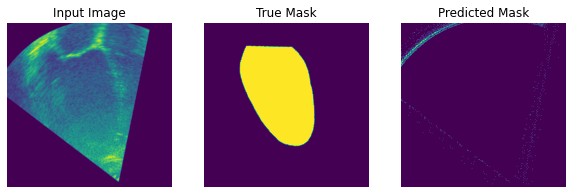

In [ ]:
show_predictions()

## Training the model

In [ ]:
import time
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
# save_model_path = '/content/gdrive/My Drive/ColabNotebooks/Datasets/models/Unet/' + timestr + '_weights-binary.hdf5'

save_model_path = '/content/gdrive/MyDrive/ColabNotebooks/Datasets/models/Unet/' + timestr + '_weights-binary.hdf5'


print(save_model_path)

/content/gdrive/MyDrive/ColabNotebooks/Datasets/models/Unet/2022-06-12_01-51-37_weights-binary.hdf5


In [ ]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', mode='auto', save_best_only=True)
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', mode='auto', save_best_only=True)

In [ ]:
cp = tf.keras.callbacks.ModelCheckpoint('weights{epoch:08d}.h5', save_weights_only=True, save_freq=10)

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Model training

In [ ]:
EPOCHS = 60

TRAIN_LENGTH = num_training_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
VALIDATION_STEPS = 96 //BATCH_SIZE//VAL_SUBSPLITS



# model_history = model.fit(train_batches, epochs=EPOCHS,
#                           steps_per_epoch=STEPS_PER_EPOCH,
#                           validation_steps=VALIDATION_STEPS,
#                           validation_data=validation_batches,
#                           callbacks=[DisplayCallback(),cp])

In [ ]:
#save final model weights
model.save('/content/drive/MyDrive/ColabNotebooks/Datasets/models/Unet/' + timestr + '_weights-binary_60_epochs_augmented.hdf5')

In [ ]:
print(validation_batches.enumerate)

<bound method DatasetV2.enumerate of <BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>>


# Learning curve from model history

In [ ]:
loss     = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = model_history.epoch


plt.figure()
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend(loc='upper right')


# dice     = model_history.history['dice_loss']
# val_dice = model_history.history['val_dice_loss']

# plt.subplot(1, 2, 2)
# plt.plot(epochs, dice, label='Training Dice Loss')
# plt.plot(epochs, val_dice, label='Validation Dice Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Dice Loss')

plt.show()

# Visualise actual performance 


In [ ]:
# model.load_weights('/content/drive/My Drive/ColabNotebooks/Datasets/models/Unet/weights-binary.hdf5')

# from keras.models import load_model
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/Datasets/models/Unet/2022-06-07_17-44-19_weights-binary_60_epochs_augmented.hdf5')
# model = load_model('my_model.h5')
# model.load_weights('my_model.h5')
# model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coeff': dice_coeff})

## Make predictions

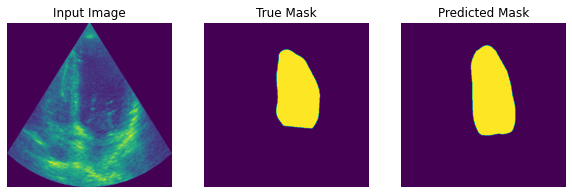

In [ ]:
show_predictions(test_batches, 1)

return a single scalar for each image

In [ ]:
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion, generate_binary_structure
from scipy.ndimage import _ni_support

def __surface_distances(result, reference, voxelspacing=None, connectivity=1):
    """
    The distances between the surface voxel of binary objects in result and their
    nearest partner surface voxel of a binary object in reference.
    """
    result = np.array(result, dtype=np.bool)
    result = np.atleast_1d(result)
    reference = np.array(reference, dtype=np.bool)
    reference = np.atleast_1d(reference)
    
    #result = np.atleast_1d(result.astype(np.bool))
    #reference = np.atleast_1d(reference.astype(np.bool))
    
    if voxelspacing is not None:
        voxelspacing = _ni_support._normalize_sequence(voxelspacing, result.ndim)
        voxelspacing = np.asarray(voxelspacing, dtype=np.float64)
        if not voxelspacing.flags.contiguous:
            voxelspacing = voxelspacing.copy()
            
    # binary structure
    footprint = generate_binary_structure(result.ndim, connectivity)
    
    # test for emptiness
    if 0 == np.count_nonzero(result): 
        raise RuntimeError('The first supplied array does not contain any binary object.')
    if 0 == np.count_nonzero(reference): 
        raise RuntimeError('The second supplied array does not contain any binary object.')    
            
    # extract only 1-pixel border line of objects
    result_border = result ^ binary_erosion(result, structure=footprint, iterations=1)
    reference_border = reference ^ binary_erosion(reference, structure=footprint, iterations=1)
    
    # compute average surface distance        
    # Note: scipys distance transform is calculated only inside the borders of the
    #       foreground objects, therefore the input has to be reversed
    dt = distance_transform_edt(~reference_border, sampling=voxelspacing)
    sds = dt[result_border]
    
    return sds

In [ ]:
def Hausdorff_Distance(reference, result, voxelspacing=None, connectivity=1):
    """
    Hausdorff Distance.
    
    Computes the (symmetric) Hausdorff Distance (HD) between the binary objects in two
    images. It is defined as the maximum surface distance between the objects.
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    voxelspacing : float or sequence of floats, optional
        The voxelspacing in a distance unit i.e. spacing of elements
        along each dimension. If a sequence, must be of length equal to
        the input rank; if a single number, this is used for all axes. If
        not specified, a grid spacing of unity is implied.
    connectivity : int
        The neighbourhood/connectivity considered when determining the surface
        of the binary objects. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        Note that the connectivity influences the result in the case of the Hausdorff distance.
        
    Returns
    -------
    hd : float
        The symmetric Hausdorff Distance between the object(s) in ```result``` and the
        object(s) in ```reference```. The distance unit is the same as for the spacing of 
        elements along each dimension, which is usually given in mm.
        
    See also
    --------
    :func:`assd`
    :func:`asd`
    
    Notes
    -----
    This is a real metric. The binary images can therefore be supplied in any order.
    """
    hd1 = __surface_distances(result, reference, voxelspacing, connectivity).max()
    hd2 = __surface_distances(reference, result, voxelspacing, connectivity).max()
    hd = max(hd1, hd2)
    return hd

In [ ]:
def Dice_Coefficient(reference, result):
    """
    Computes the Dice coefficient (also known as Sorensen index) between the binary objects in two images.

    result : Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    """
    result = np.array(result, dtype=np.bool)
    result = np.atleast_1d(result)
    result = tf.reshape(result, [-1])

    reference = np.array(reference, dtype=np.bool)
    reference = np.atleast_1d(reference)
    reference = tf.reshape(reference, [-1])
    
    intersection = np.count_nonzero(result & reference)
    
    size_i1 = np.count_nonzero(result)
    size_i2 = np.count_nonzero(reference)
    
    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0
    
    return dc

In [ ]:
for image, mask in test_batches.take(5):
  pred_mask = model.predict(image)
  #tf.print('dice coefficient = ', dice_coeff(mask[0], create_mask(pred_mask)))
  #print('dice coefficient = ', Dice_Coefficient(mask[0], create_mask(pred_mask)))
  #print('Hausdorff_Distance = ', Hausdorff_Distance(mask[0], create_mask(pred_mask)))
  DC = Dice_Coefficient(mask[0], create_mask(pred_mask))
  print(DC/(2-DC))

  #print("Image shape: ", image.shape)
  #print("mask: ", mask.shape)
  #print("pred_mask: ", pred_mask.shape)

In [ ]:
for image, mask in test_batches.take(5):
  pred_mask = model.predict(image)
  print(Hausdorff_Distance(mask[0], create_mask(pred_mask)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


23.53720459187964
68.79680225126747
19.72308292331602
16.401219466856727
13.0


# Graph Video Frames Segments

In [ ]:
import cv2
import os

In [ ]:
VIDEO_PATH = "/content/drive/MyDrive/ColabNotebooks/Datasets/EchoTiming/Videos/0a0ff3790abd419e_b.avi"#"path/to/video/folder" # Change this
IMAGE_PATH = "/content/drive/MyDrive/ColabNotebooks/Datasets/extracted_videos/" #"path/to/image/folder" # ...and this 
MASK_PATH = "/content/drive/MyDrive/ColabNotebooks/Datasets/extracted_masks/" 

EXTENSION = ".jpg"

In [ ]:
vidcap = cv2.VideoCapture(VIDEO_PATH)
success,image = vidcap.read()
count = 1

In [ ]:
while success:
  cv2.imwrite(IMAGE_PATH + "frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print("read new frame # %d : " % count, success)
  count += 1

read new frame # 1 :  True
read new frame # 2 :  True
read new frame # 3 :  True
read new frame # 4 :  True
read new frame # 5 :  True
read new frame # 6 :  True
read new frame # 7 :  True
read new frame # 8 :  True
read new frame # 9 :  True
read new frame # 10 :  True
read new frame # 11 :  True
read new frame # 12 :  True
read new frame # 13 :  True
read new frame # 14 :  True
read new frame # 15 :  True
read new frame # 16 :  True
read new frame # 17 :  True
read new frame # 18 :  True
read new frame # 19 :  True
read new frame # 20 :  True
read new frame # 21 :  True
read new frame # 22 :  True
read new frame # 23 :  True
read new frame # 24 :  True
read new frame # 25 :  True
read new frame # 26 :  True
read new frame # 27 :  True
read new frame # 28 :  True
read new frame # 29 :  True
read new frame # 30 :  True
read new frame # 31 :  True
read new frame # 32 :  True
read new frame # 33 :  True
read new frame # 34 :  True
read new frame # 35 :  True
read new frame # 36 :  True
r

In [ ]:
# image processing
for filename in os.listdir(IMAGE_PATH):
    if filename.endswith(".jpg"): 
        img = cv2.imread(IMAGE_PATH + filename)
        # color grade image
        brightness = 110
        contrast = -10
        img = np.int16(img)
        img = img * (contrast/127+1) - contrast + brightness
        img = np.clip(img, 0, 255)
        img = np.uint8(img)
        ###
        # resize image
        img = cv2.resize(img, (512,512))
        ### 
        # mask image
        mask = cv2.imread("/content/drive/MyDrive/ColabNotebooks/Datasets/mask_image/mask_image.png")
        final = cv2.bitwise_and(img, mask)
        cv2.imwrite(IMAGE_PATH + filename, final)
        continue
    else:
        continue

In [ ]:
def display_frame(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list))
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
    #plt.colorbar()
  plt.show()

In [ ]:
def predict_frame(images, num=1):
  if images:
    pred_mask = model.predict(images)
    display_frame([images, create_mask(pred_mask)])

  else:
    display_frame([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


In [ ]:
def parse_frame(img_path):

    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    return image

def load_frame(datapoint):
    
    input_image = tf.image.resize(datapoint, (SIZE, SIZE))
    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    return input_image


In [ ]:
# load images into tensor
frames = tf.data.Dataset.list_files(IMAGE_PATH + "*.jpg", shuffle=False)
frames = frames.map(parse_frame)

In [ ]:
SIZE = 512
frames = frames.map(load_frame)

In [ ]:
def create_mask_frame(predict_mask_frame):
  #print(predict_mask_frame.shape)
  #predict_mask_frame = tf.argmax(predict_mask_frame, axis=-1)
  predict_mask_frame = tf.greater(predict_mask_frame, 0.5)
  predict_mask_frame = tf.dtypes.cast(predict_mask_frame, tf.float32)
  #predict_mask_frame = predict_mask_frame[..., tf.newaxis]
  predict_mask_frame = predict_mask_frame[0]
  #print(predict_mask_frame.shape)
  return predict_mask_frame

In [ ]:
def predict_frames(dataset=None):
  if dataset:
    counter = 1
    for image in dataset:
      pred_mask = model.predict(image)
      display_frame([image[0], create_mask_frame(pred_mask), ], frame_name=counter)
      counter = counter + 1
  else:
    display_frame([sample_image, sample_mask,
             create_mask_frame(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
# this function saves mask images as png

def display_frame(display_list, frame_name):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'Predicted Mask']

  for i in range(len(display_list)):
    # plt.subplot(1, len(display_list), i+1)
    # plt.title(title[i])
    # plt.plot(display_list[-1])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[-1]))

    tf.keras.preprocessing.image.save_img(MASK_PATH + str(frame_name) + ".png", x=display_list[-1], scale=False)
    plt.axis('off')
    #plt.colorbar()
  # plt.show()

In [ ]:
frame_batches = frames.batch(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


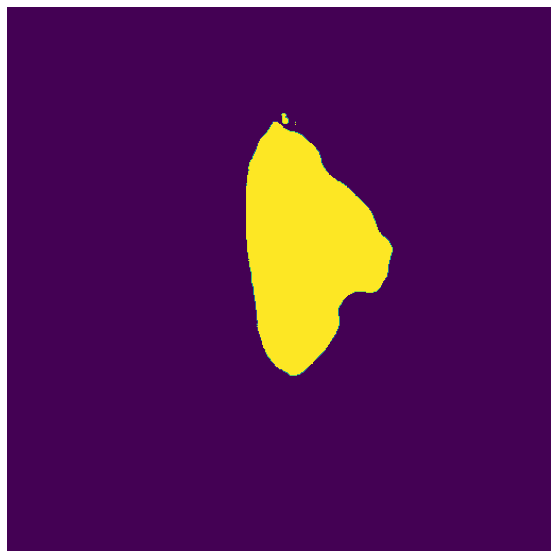

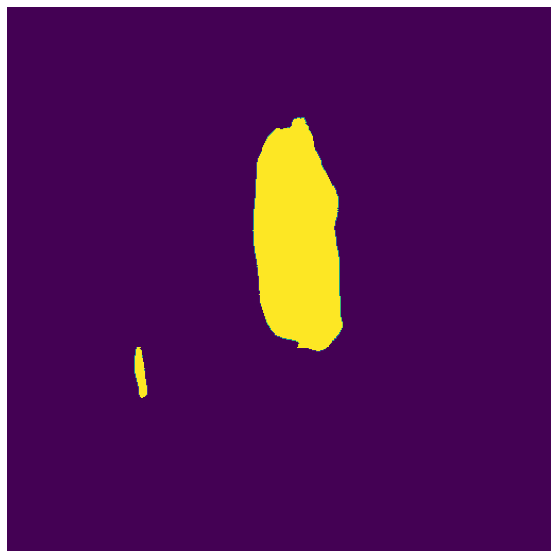

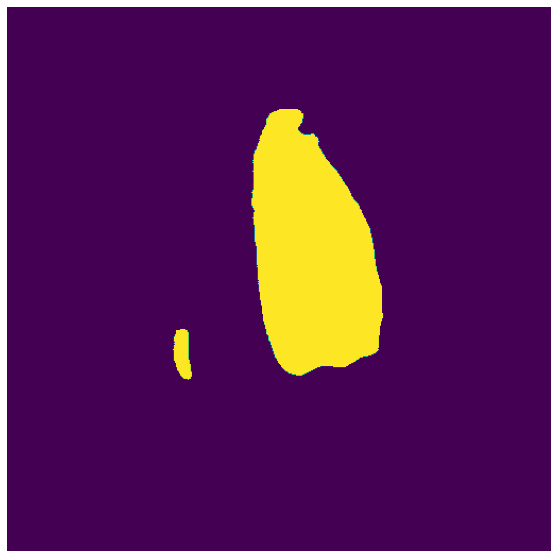

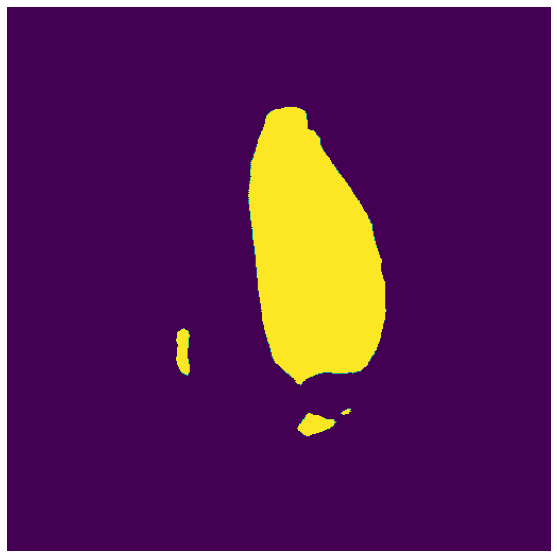

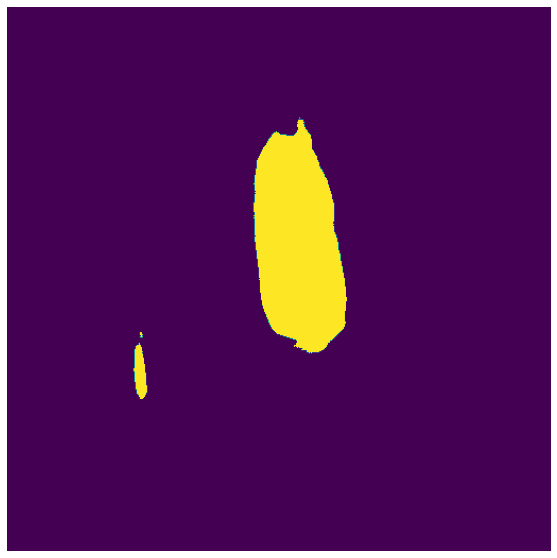

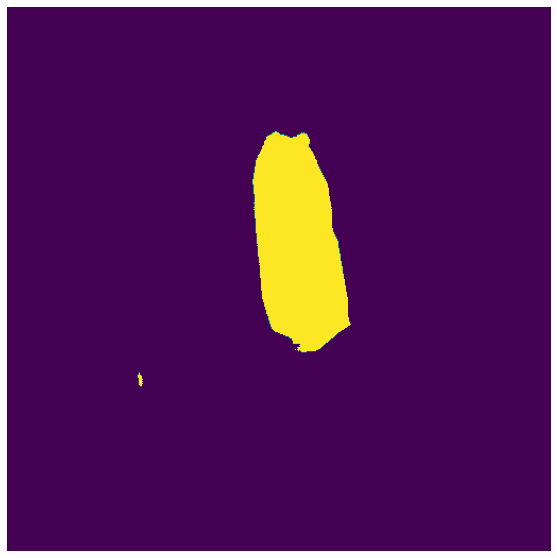

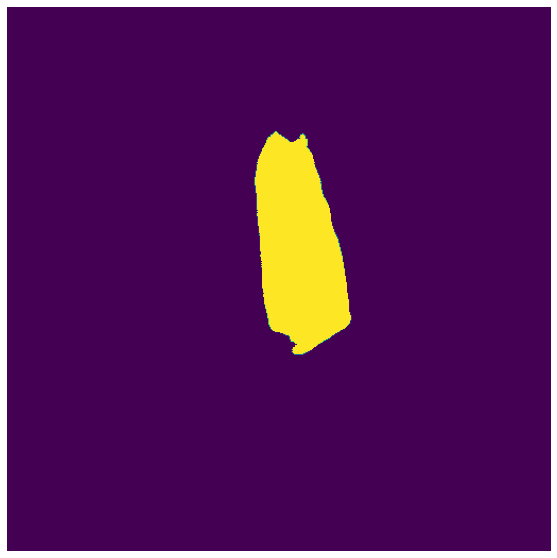

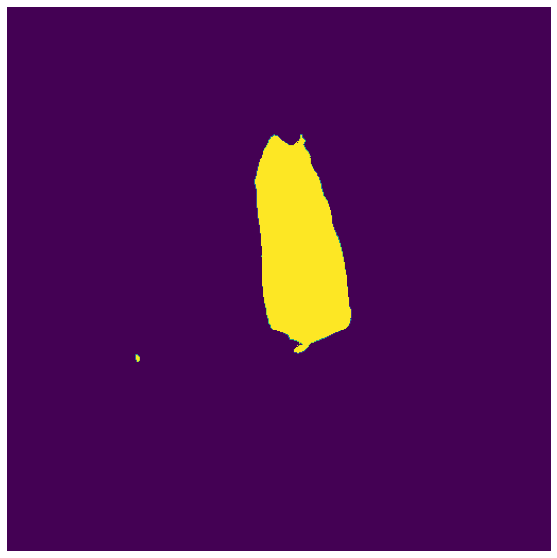

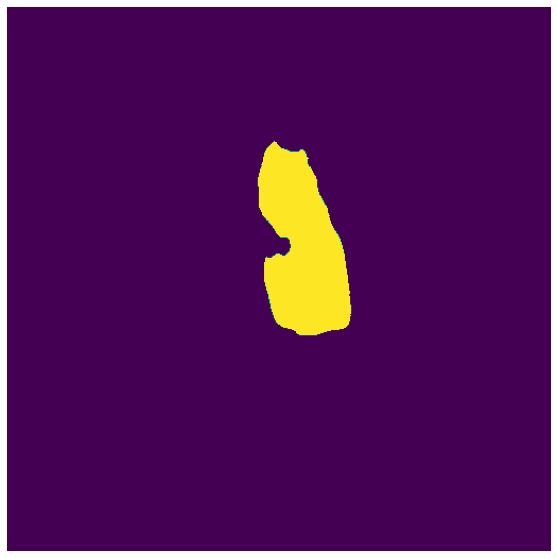

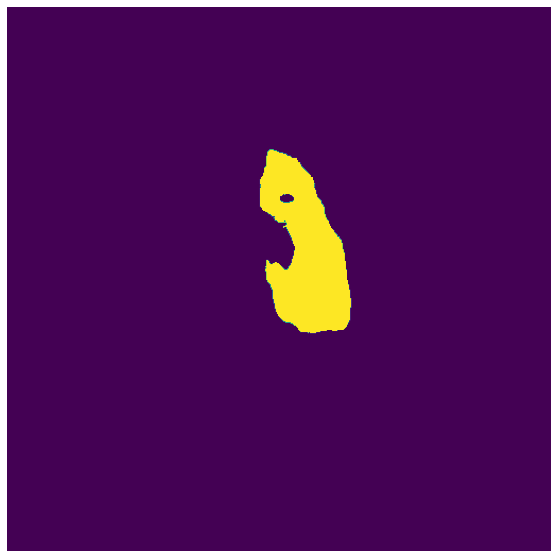

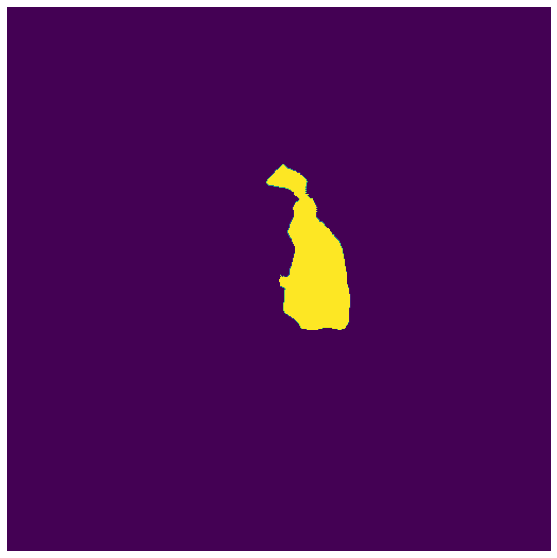

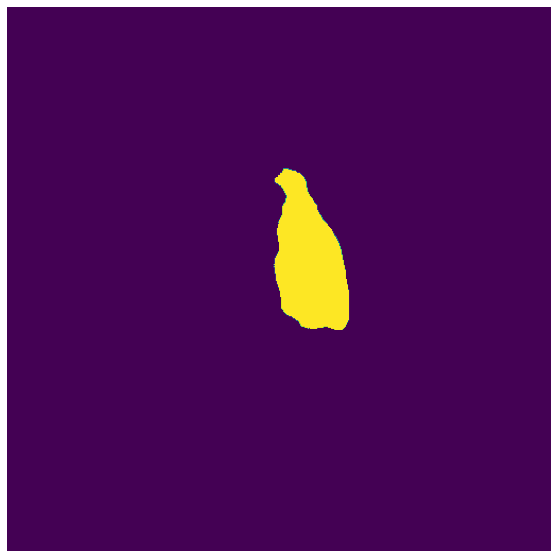

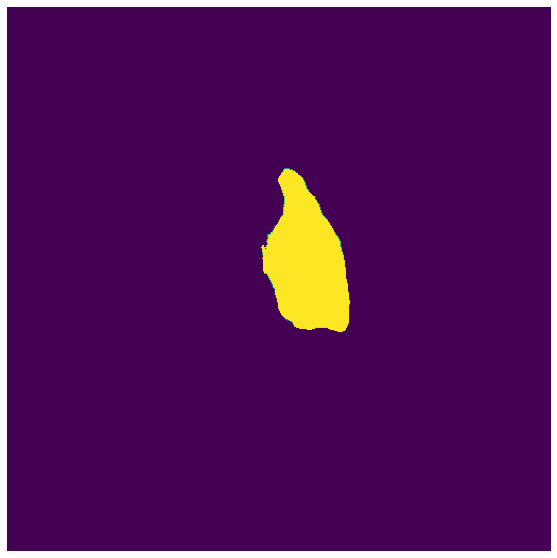

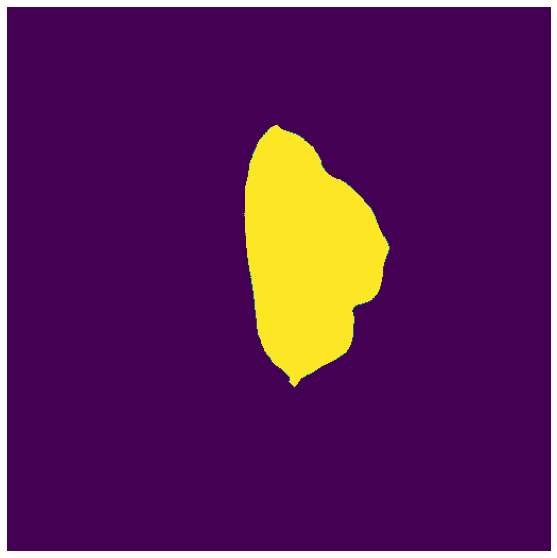

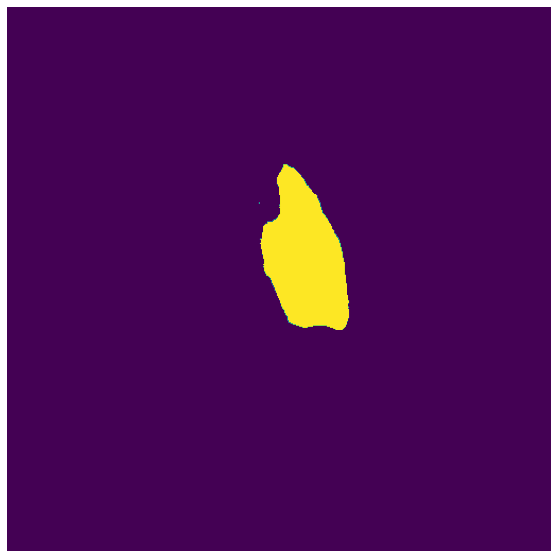

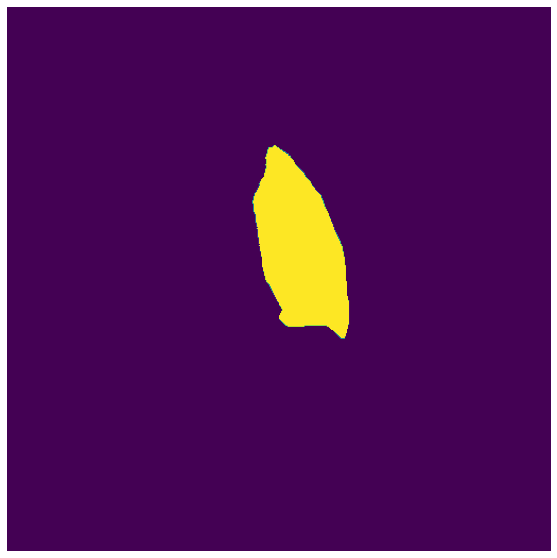

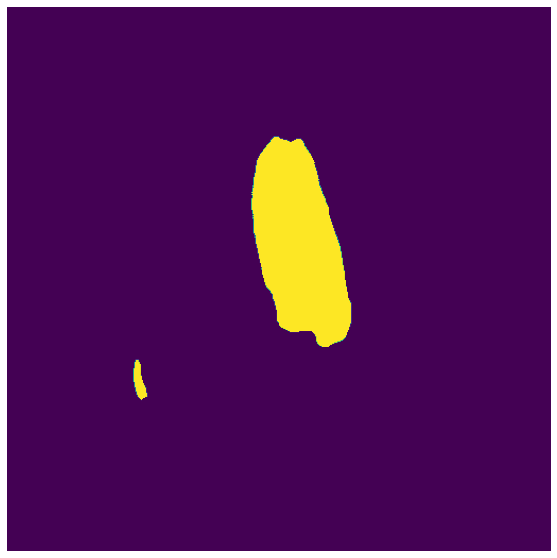

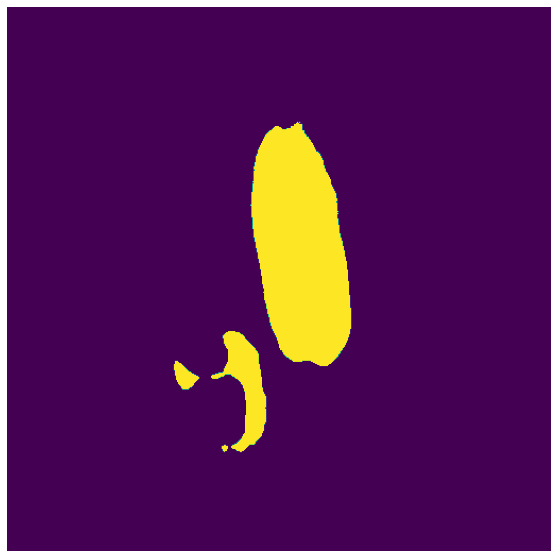

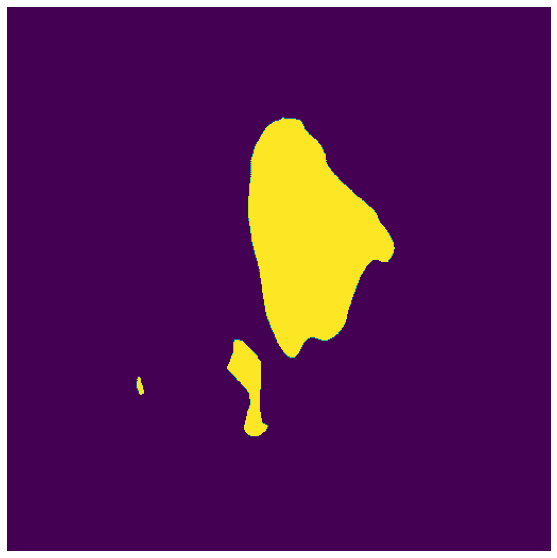

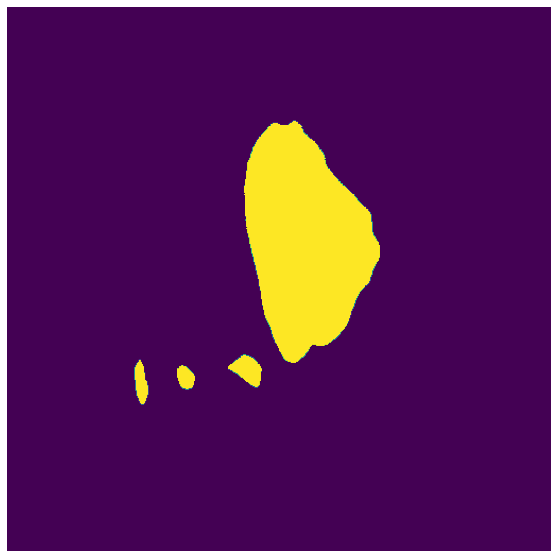

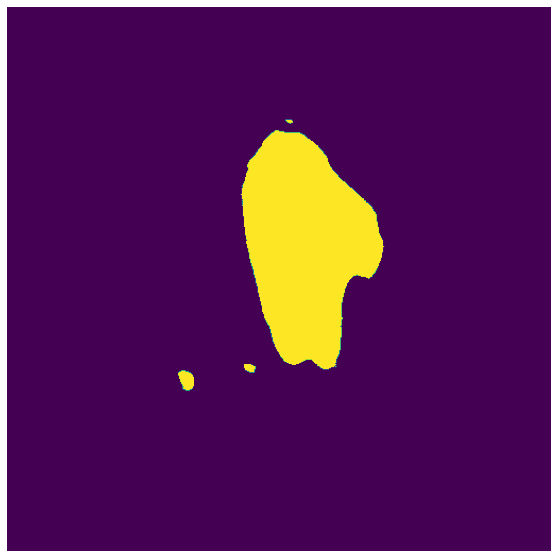

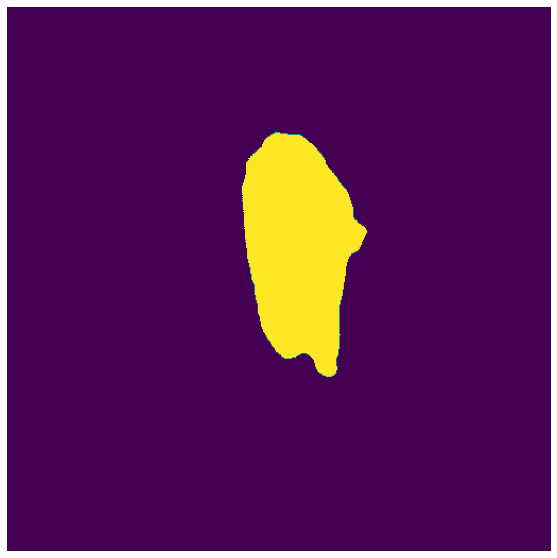

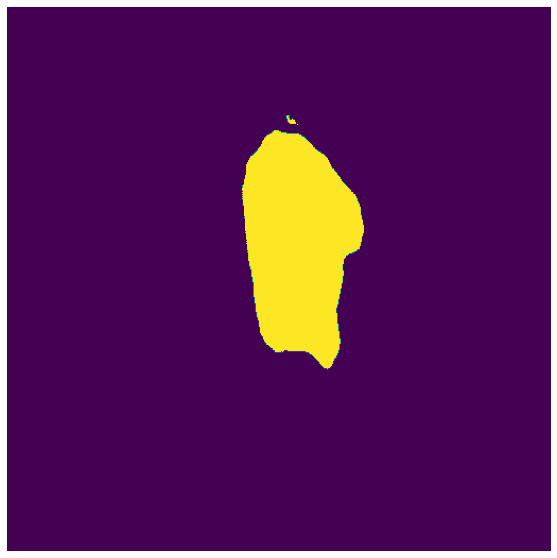

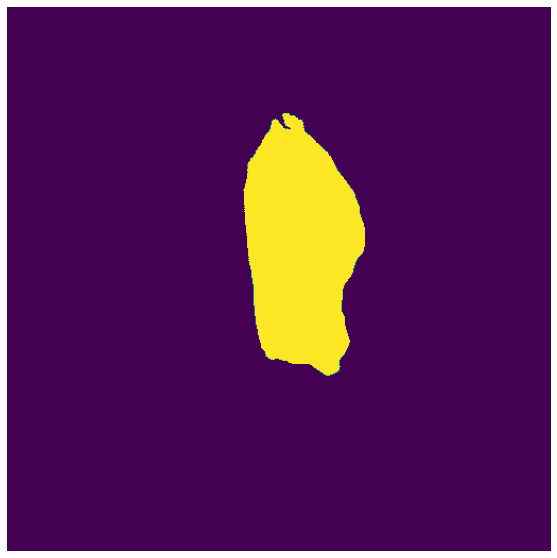

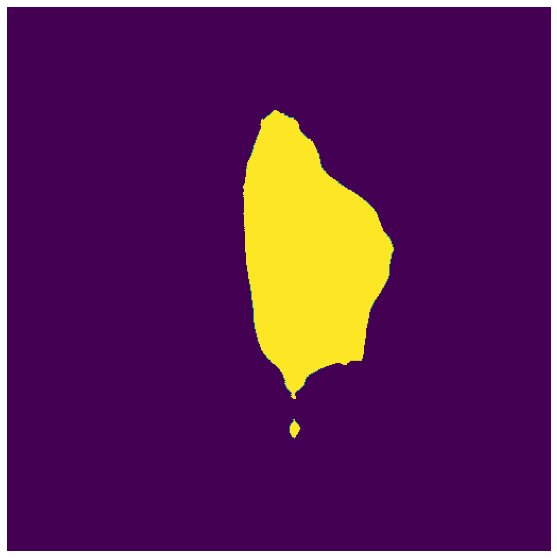

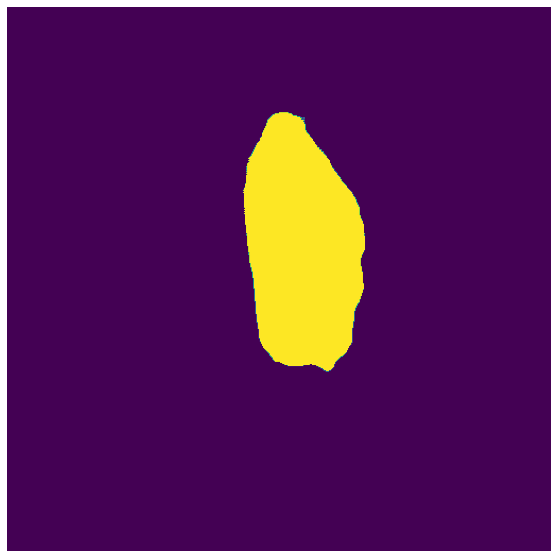

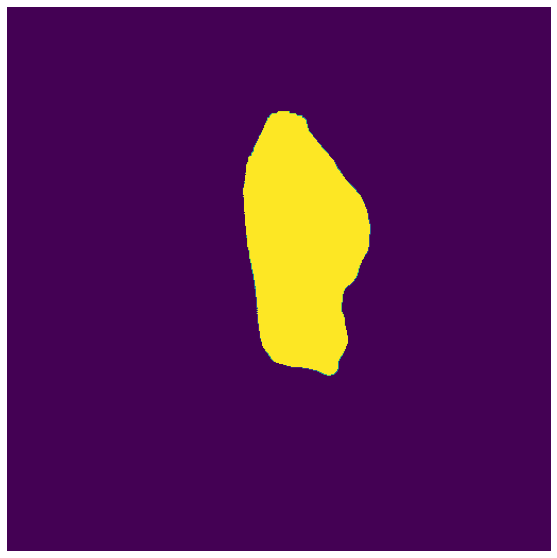

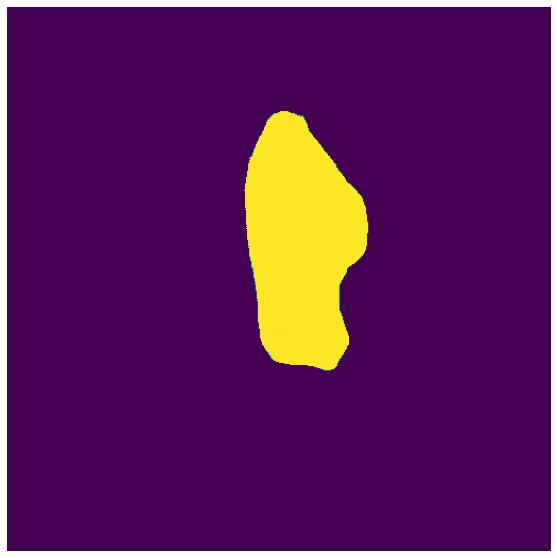

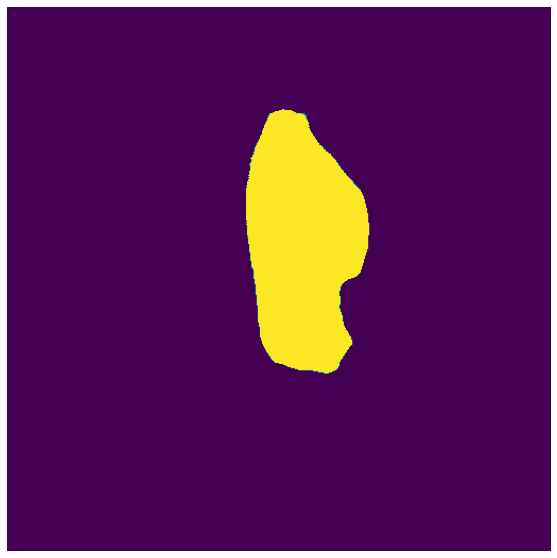

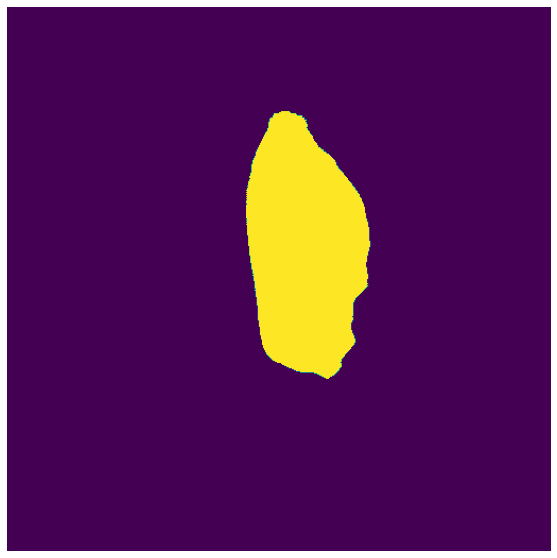

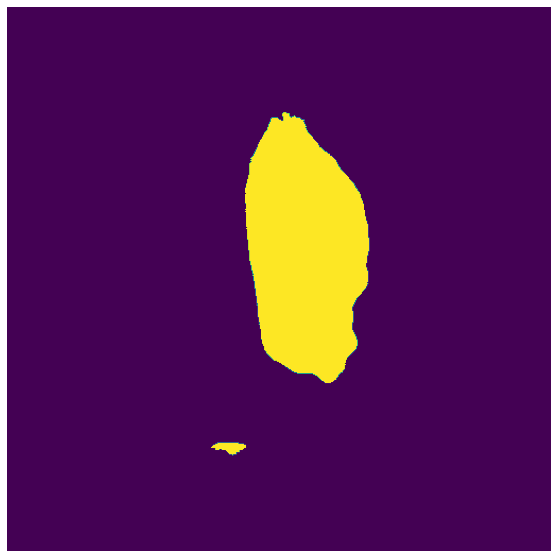

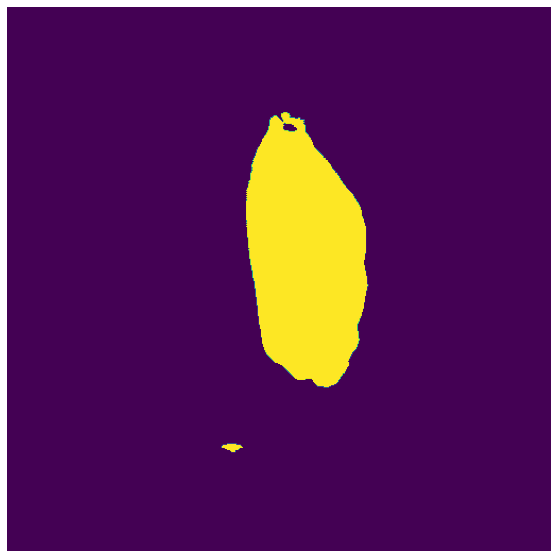

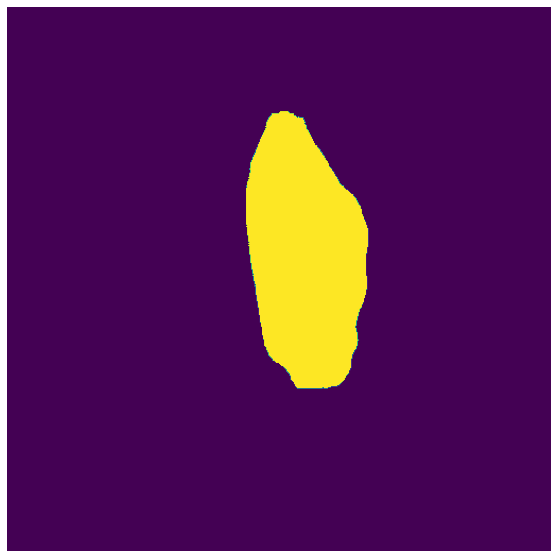

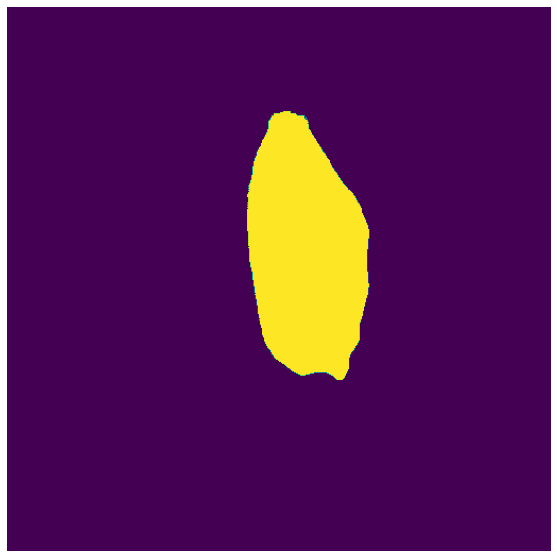

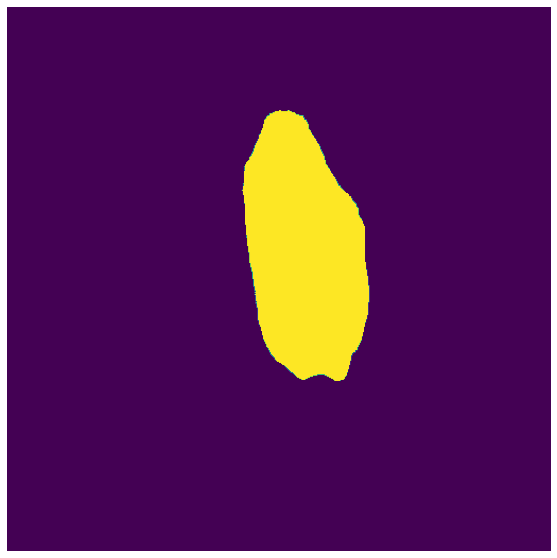

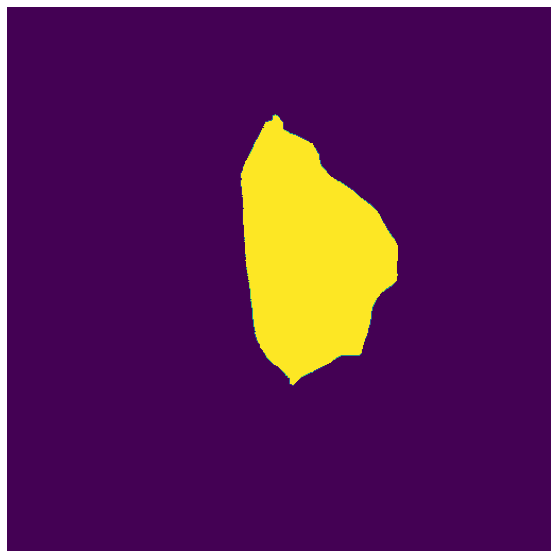

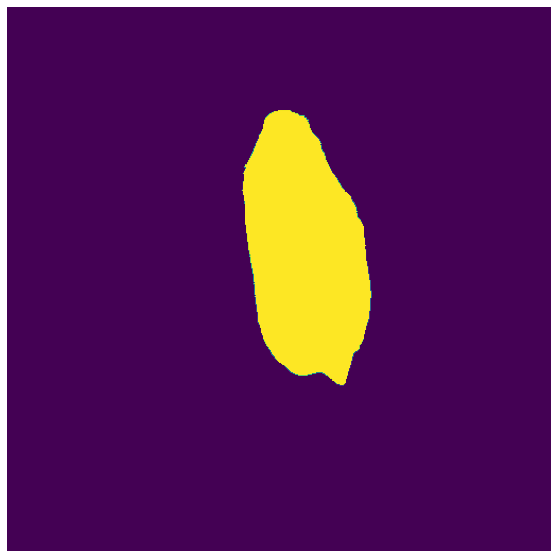

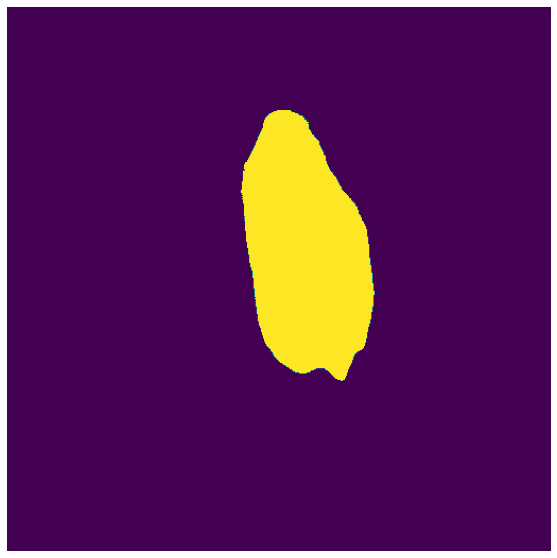

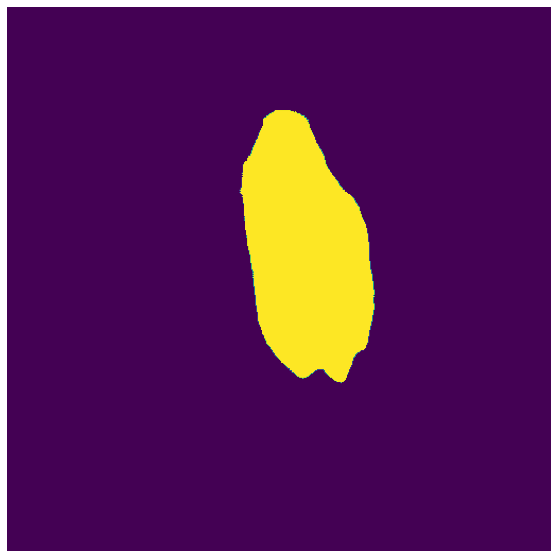

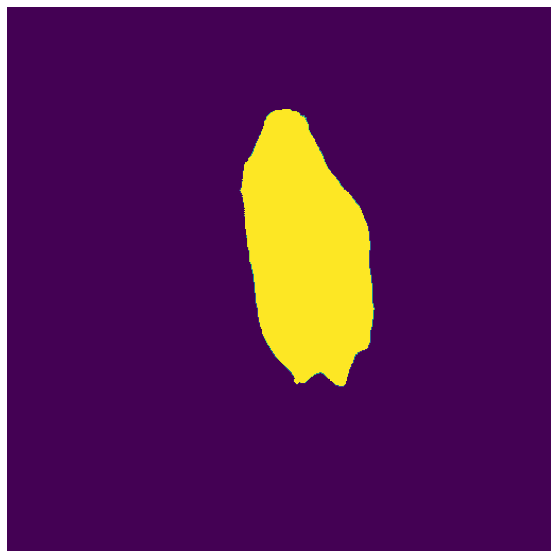

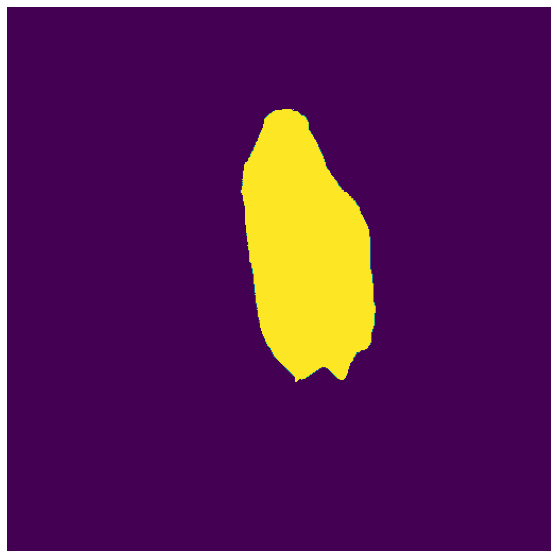

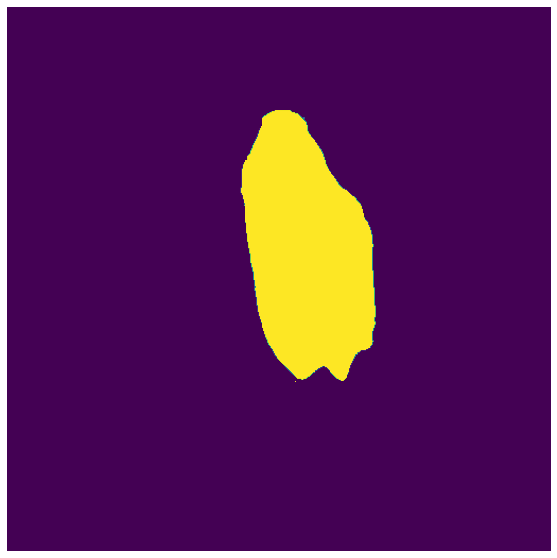

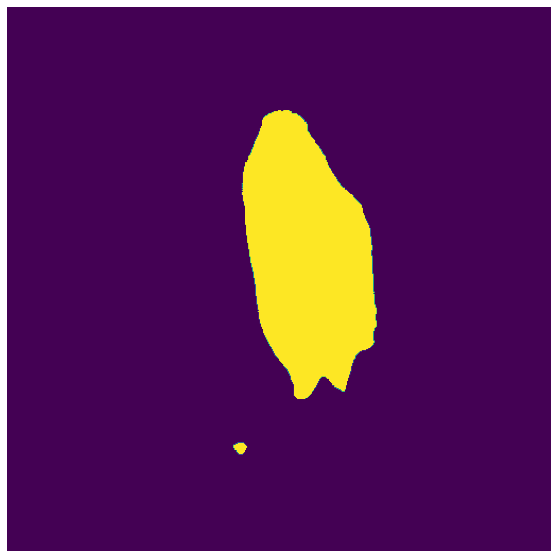

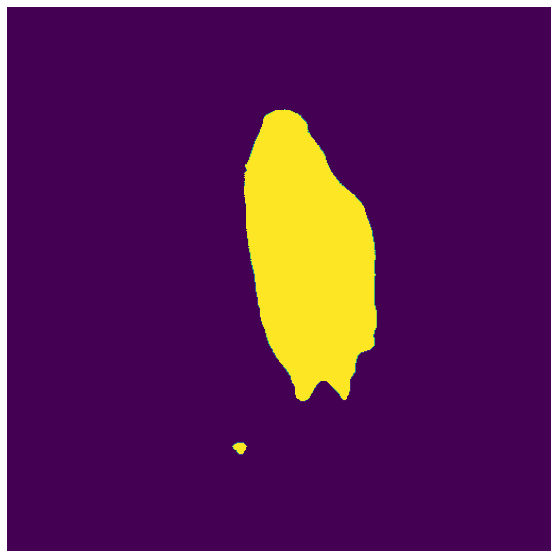

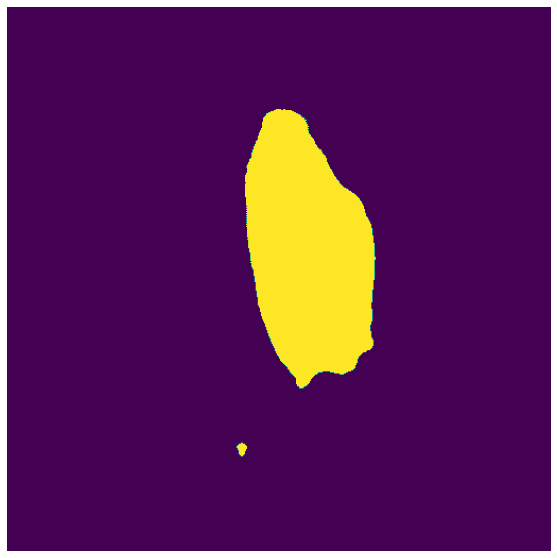

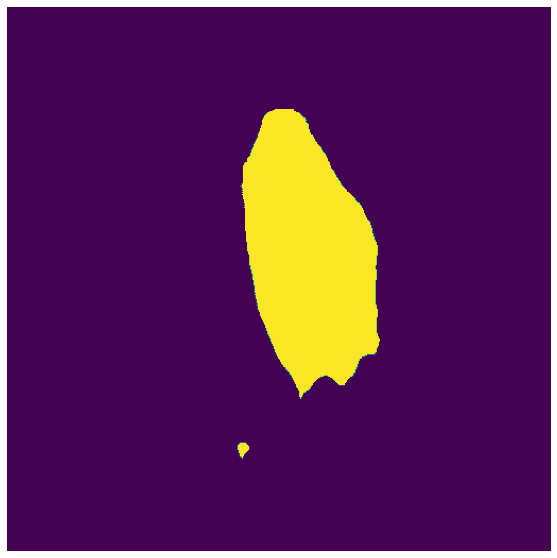

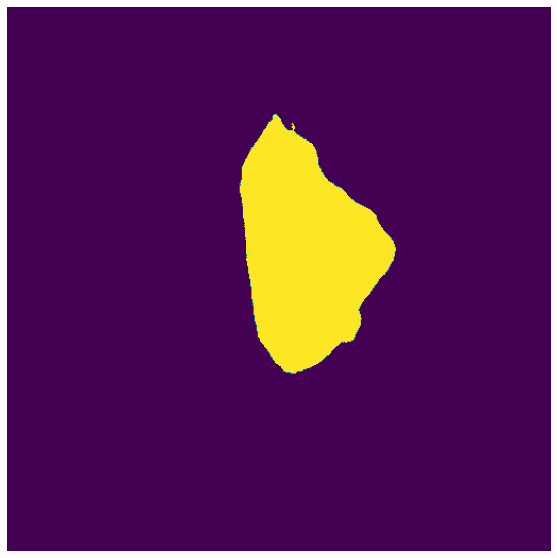

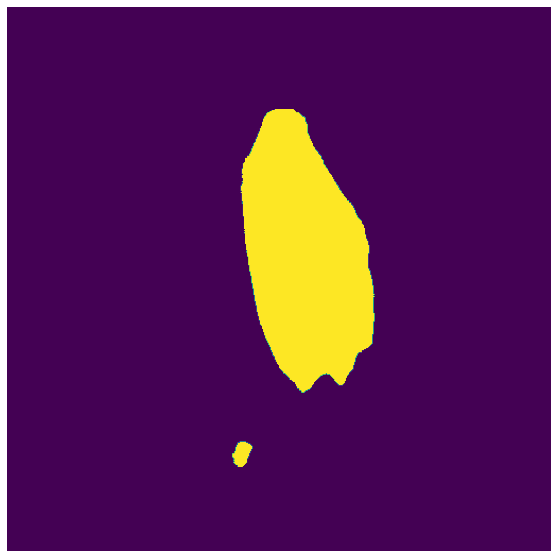

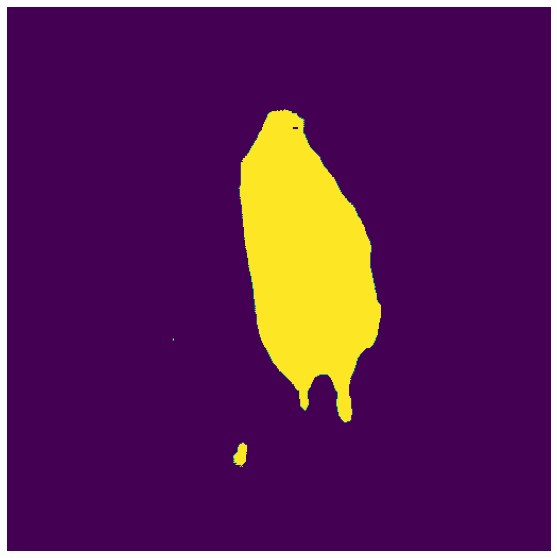

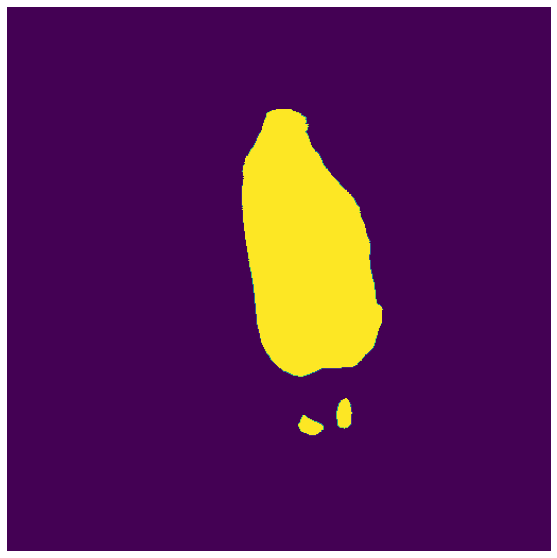

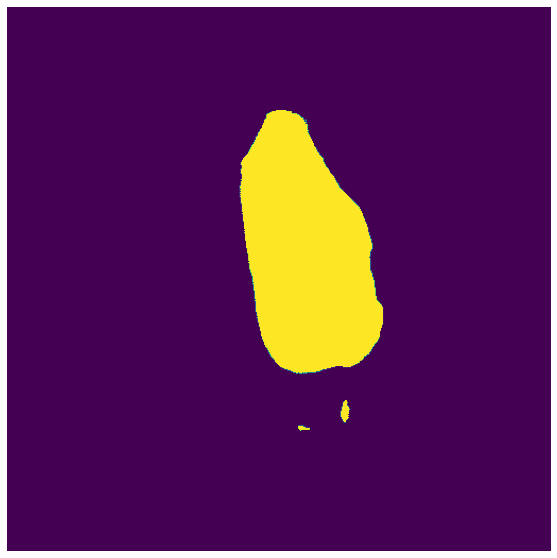

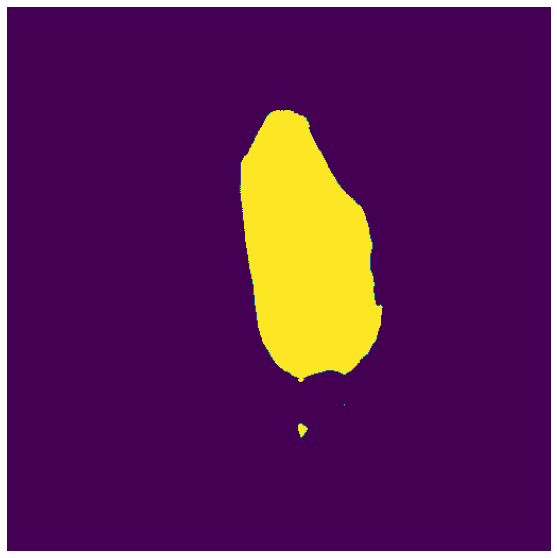

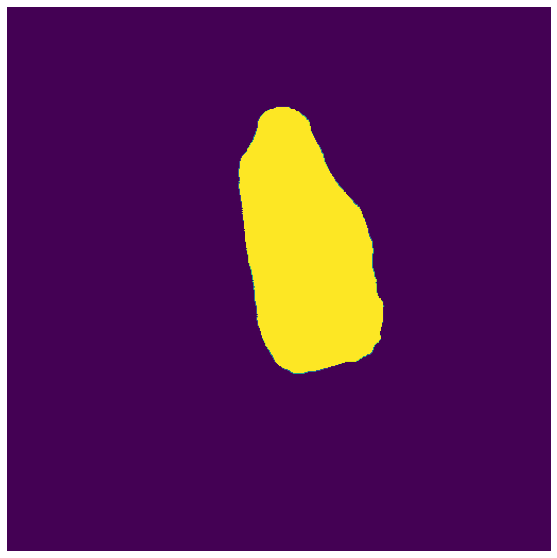

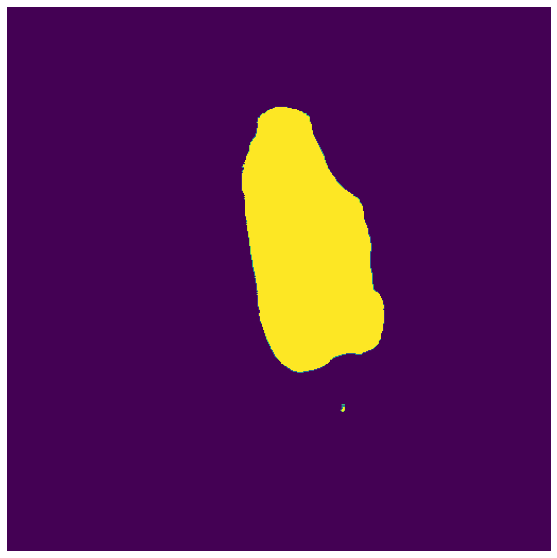

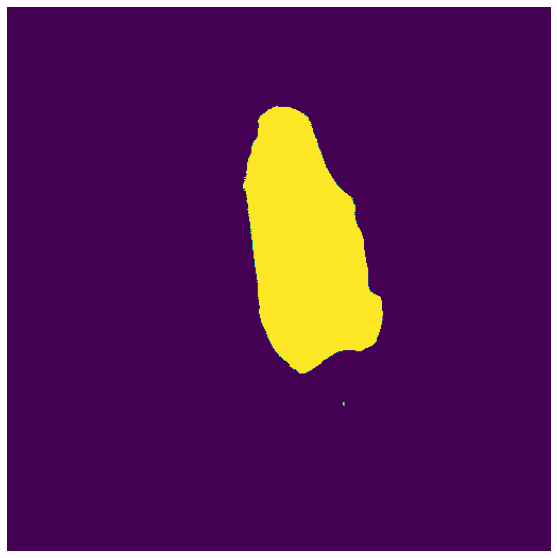

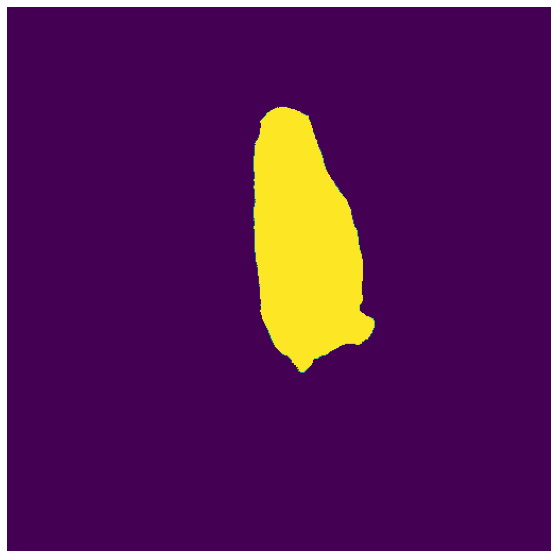

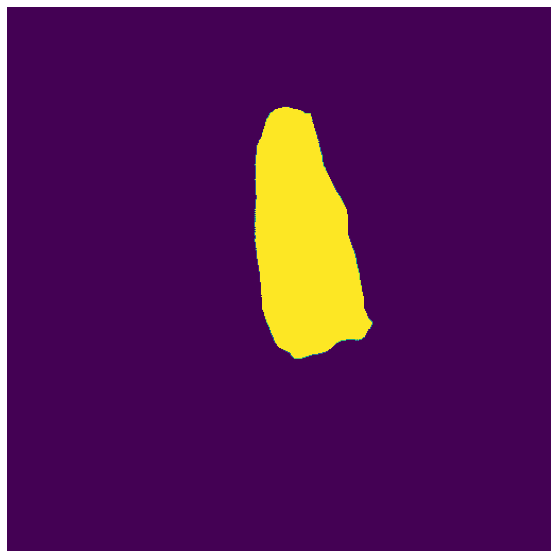

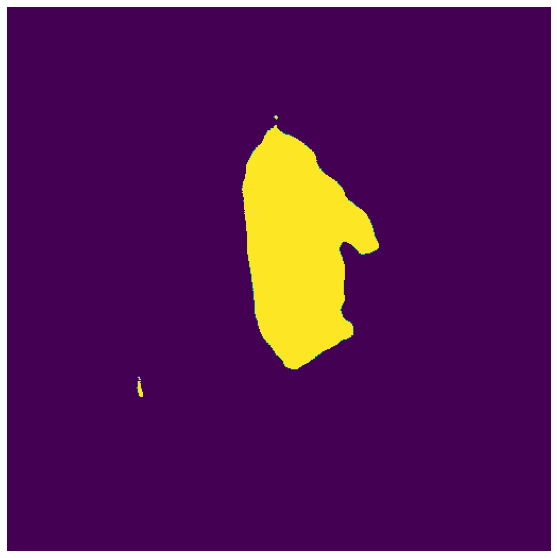

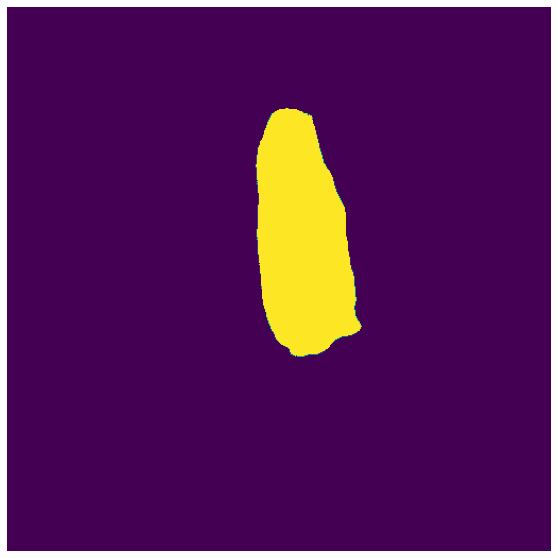

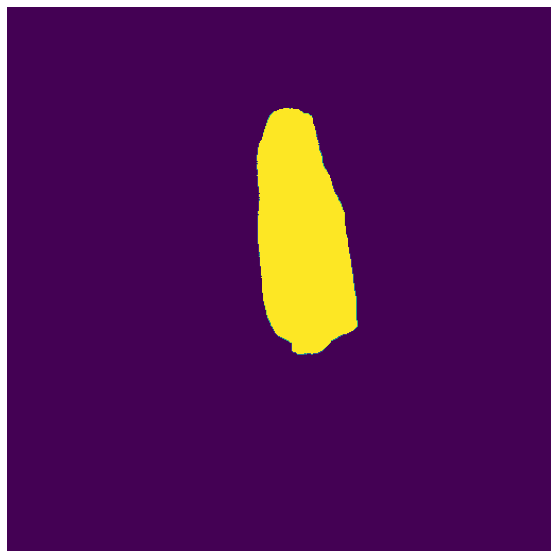

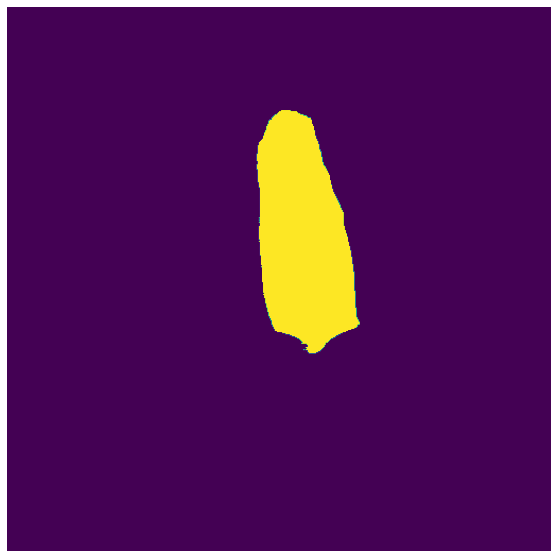

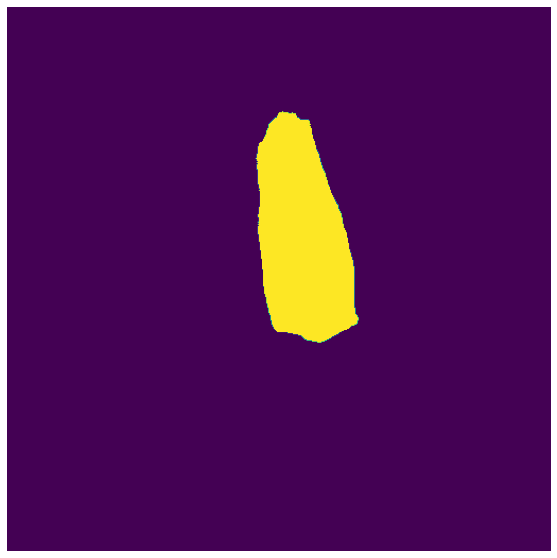

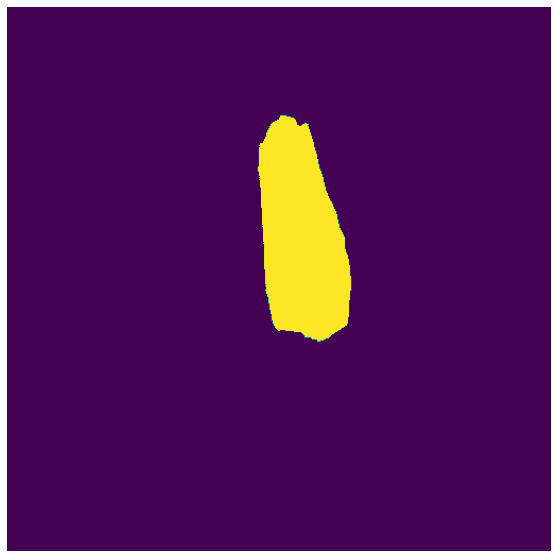

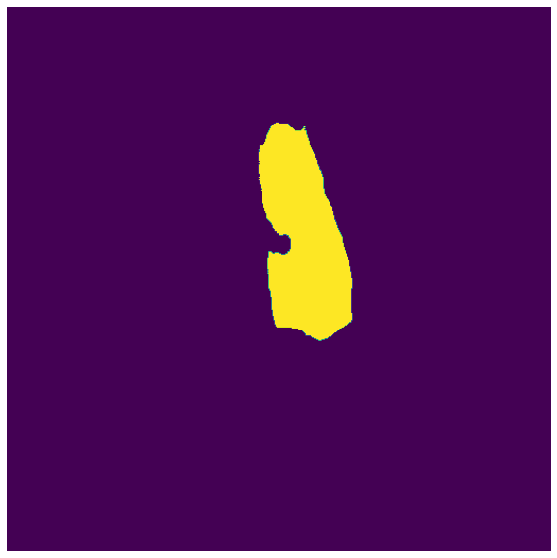

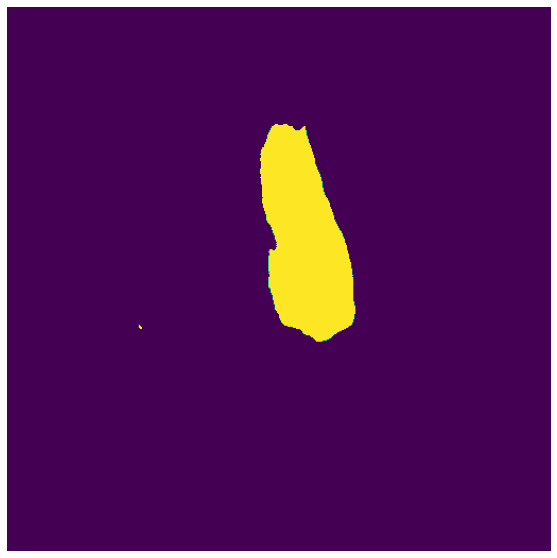

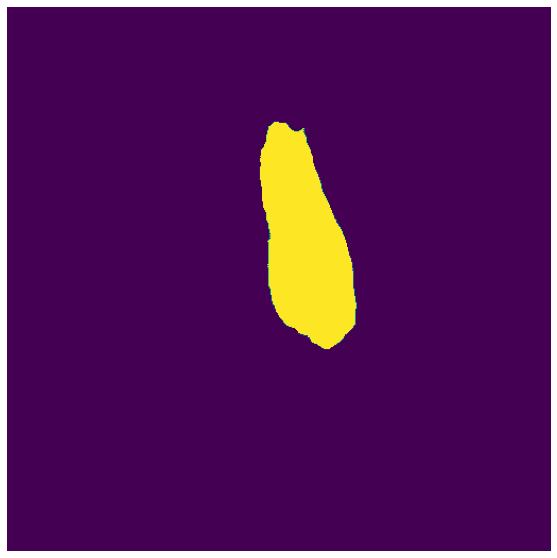

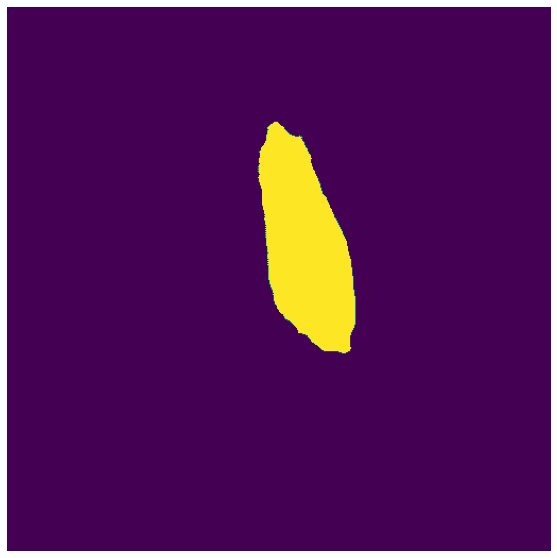

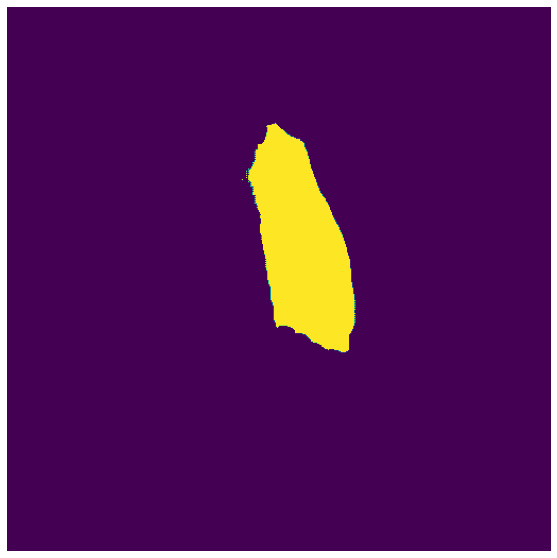

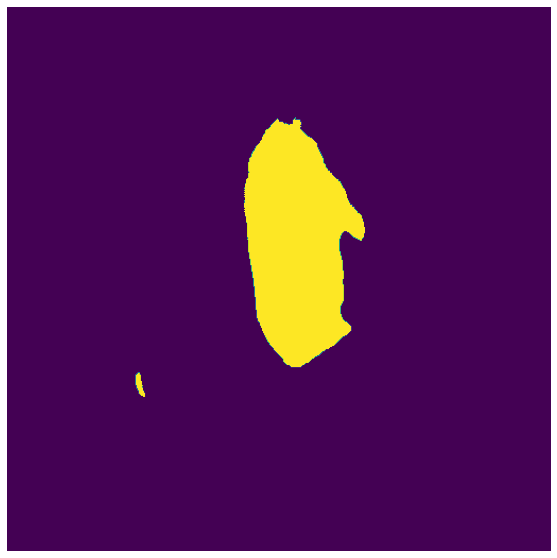

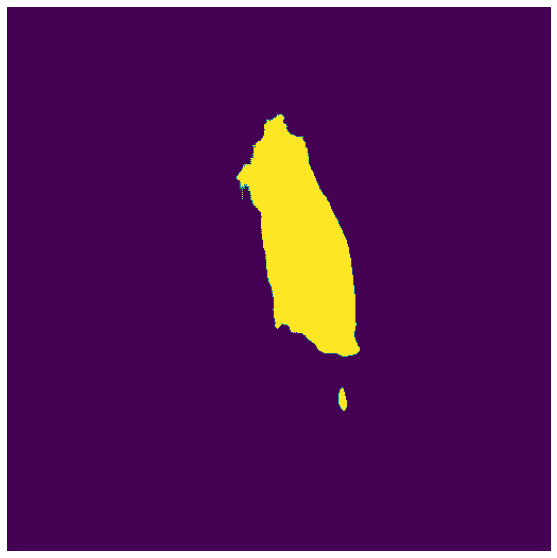

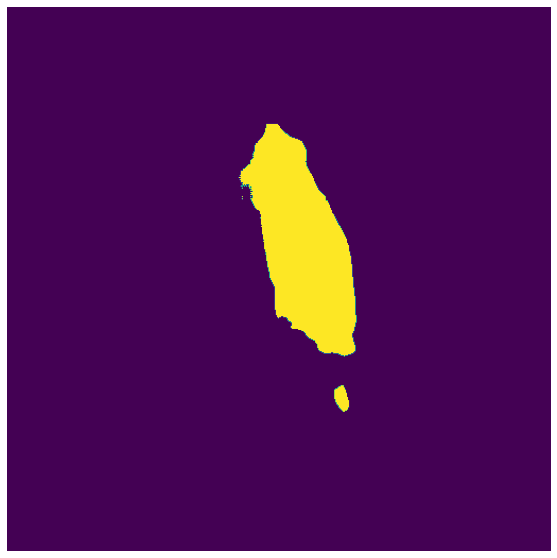

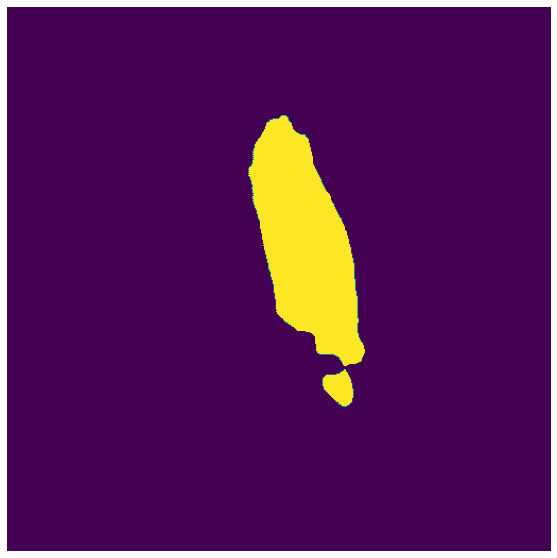

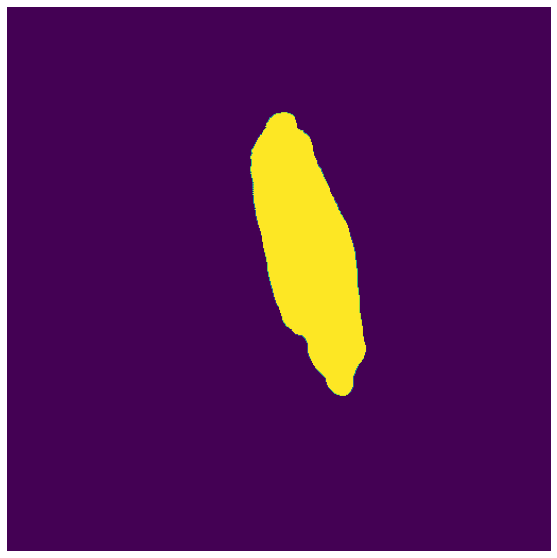

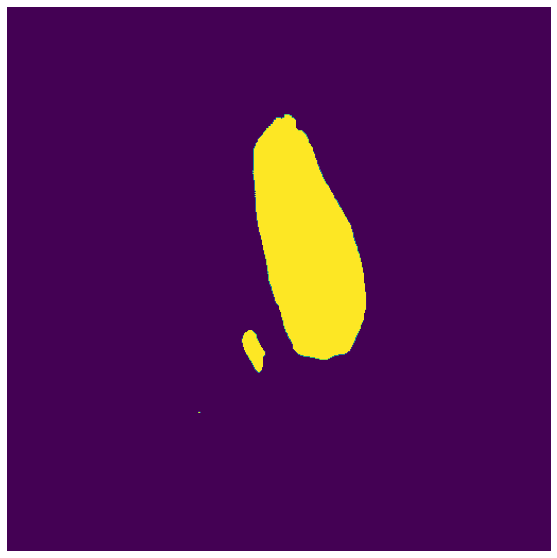

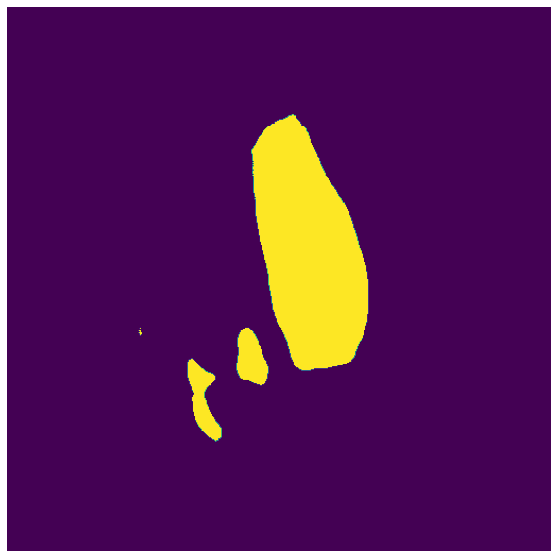

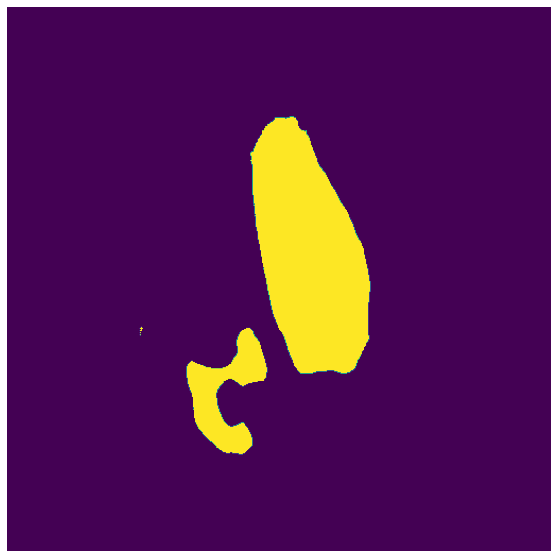

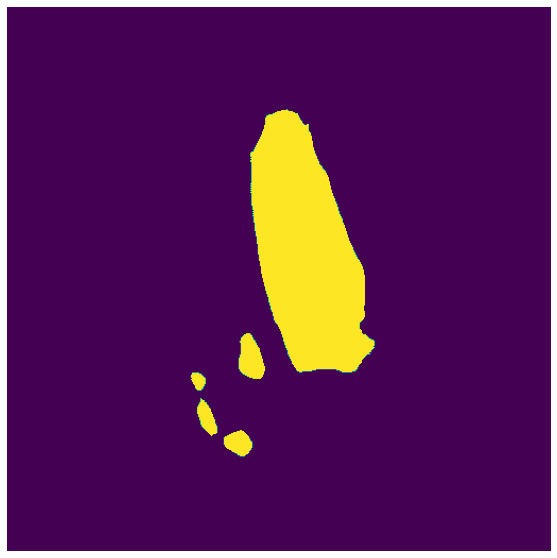

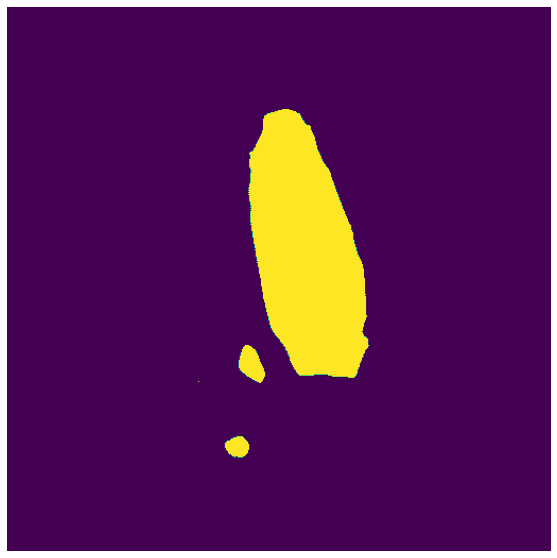

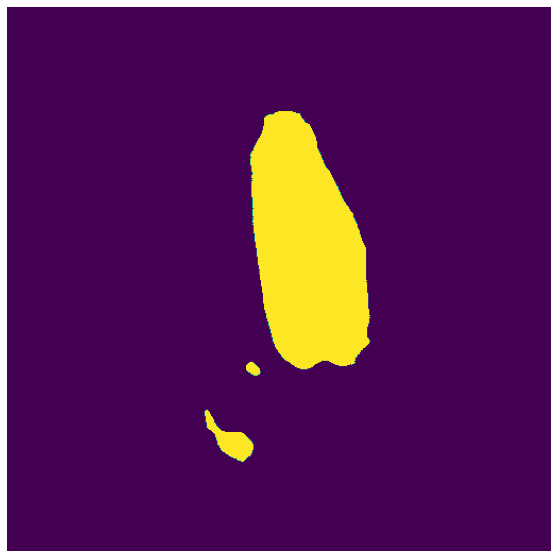

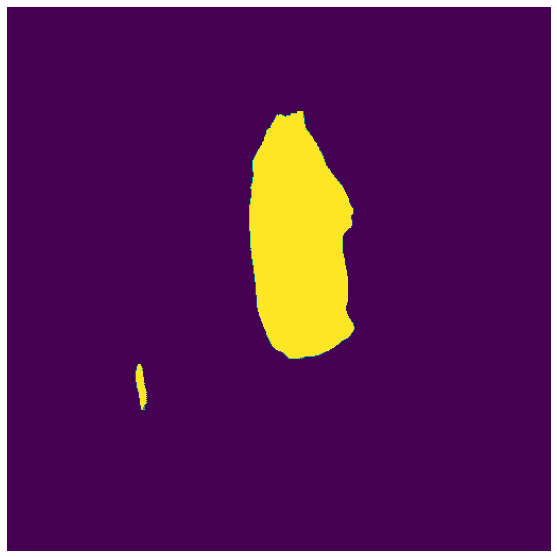

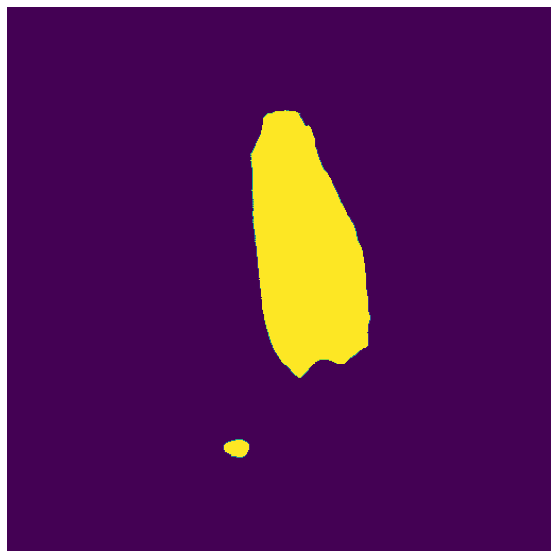

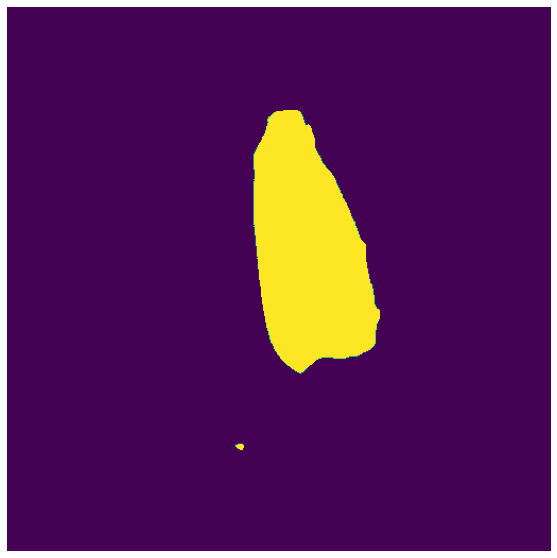

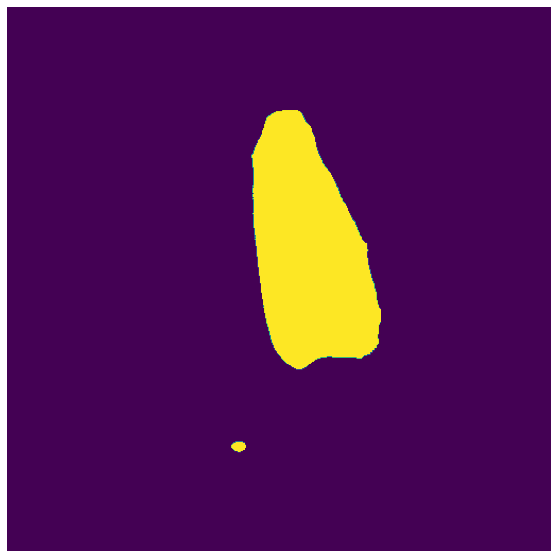

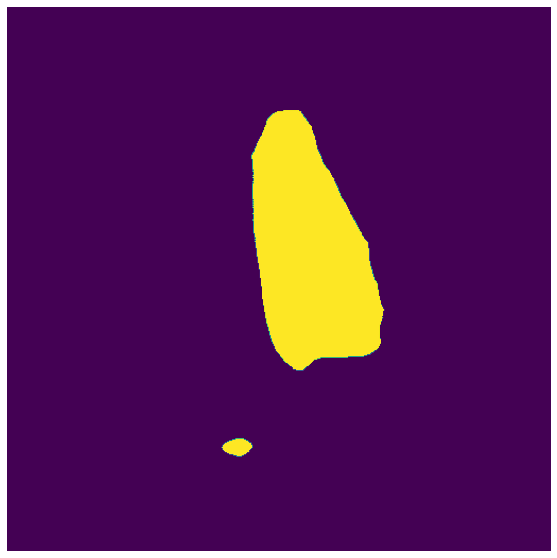

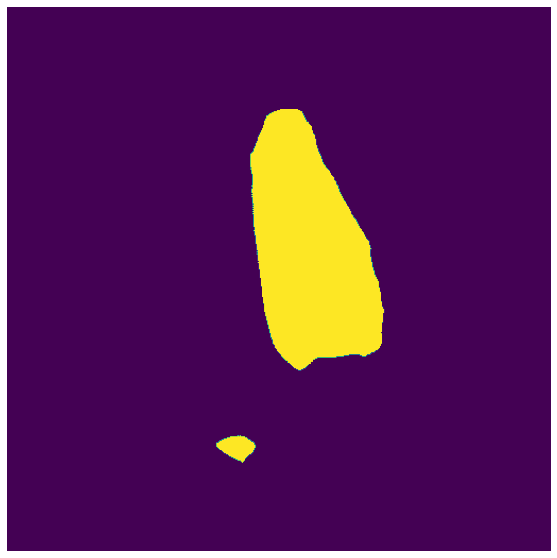

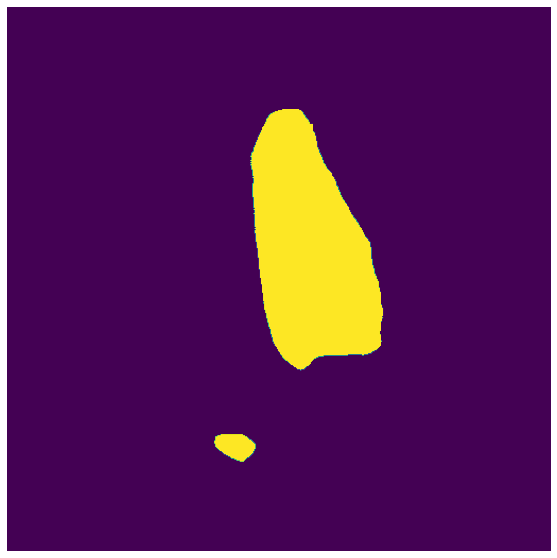

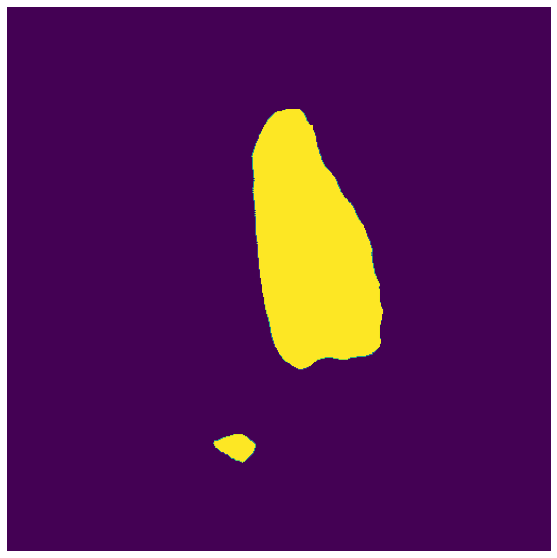

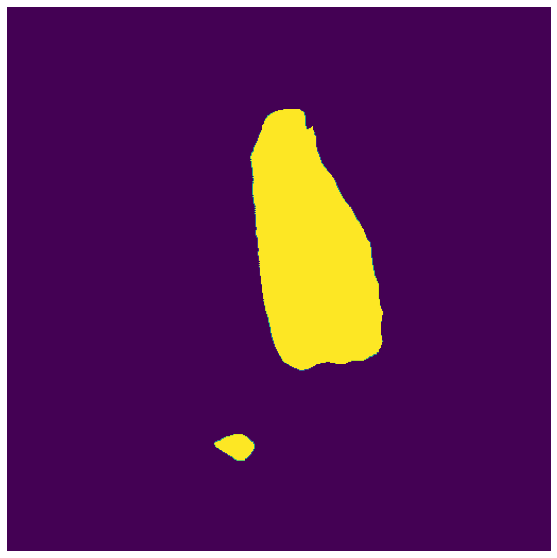

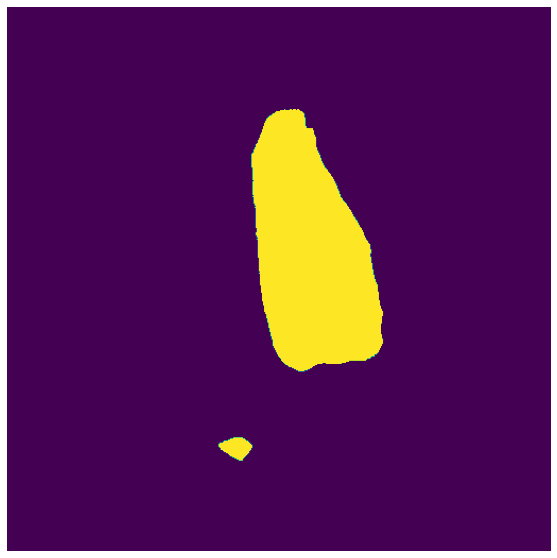

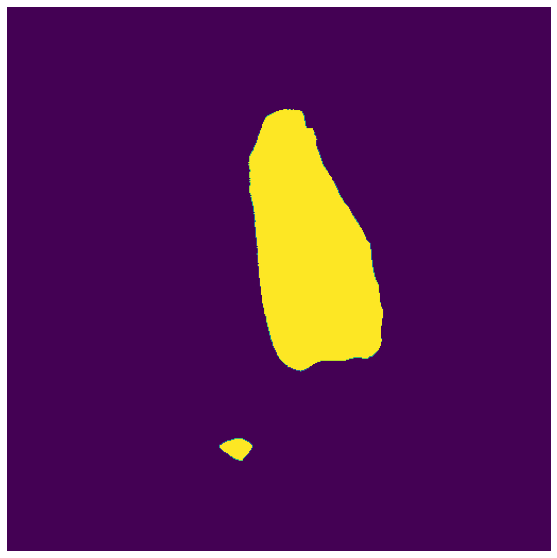

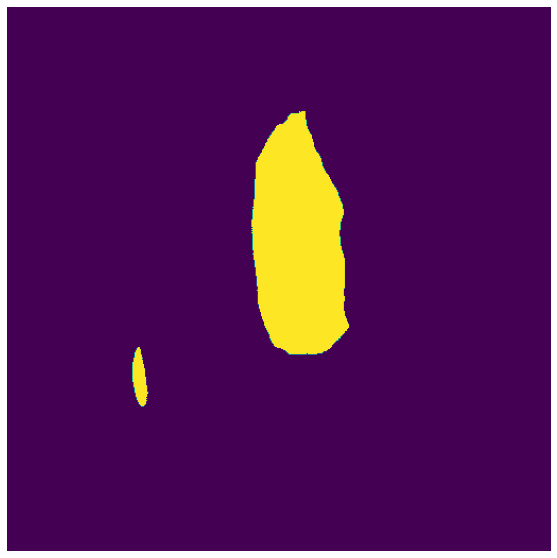

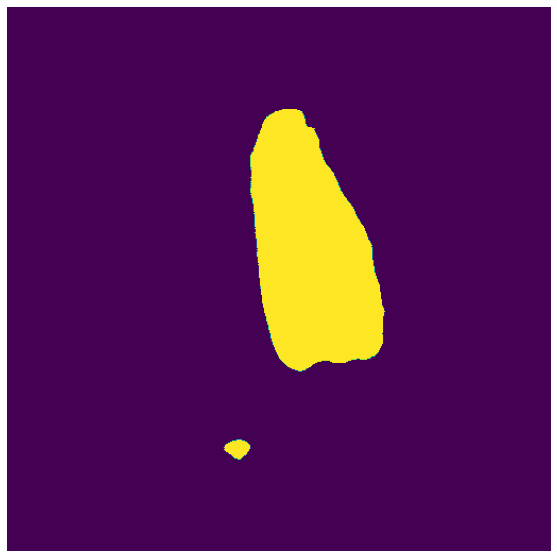

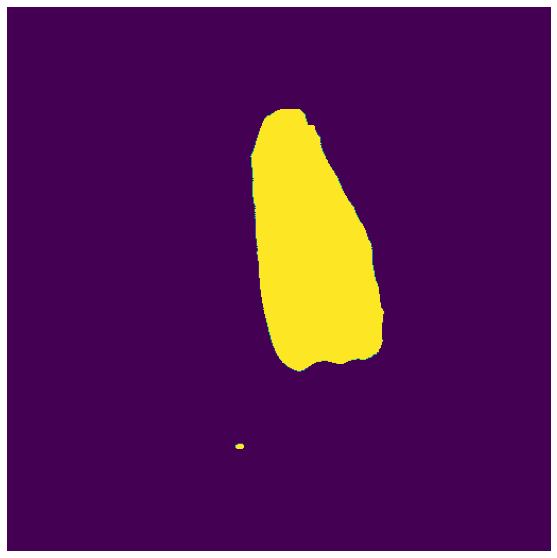

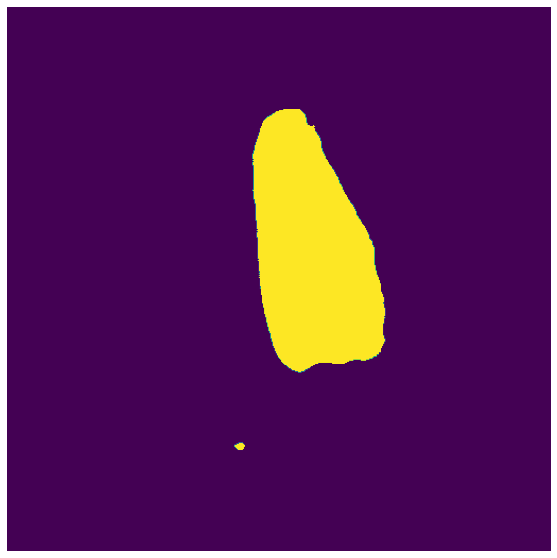

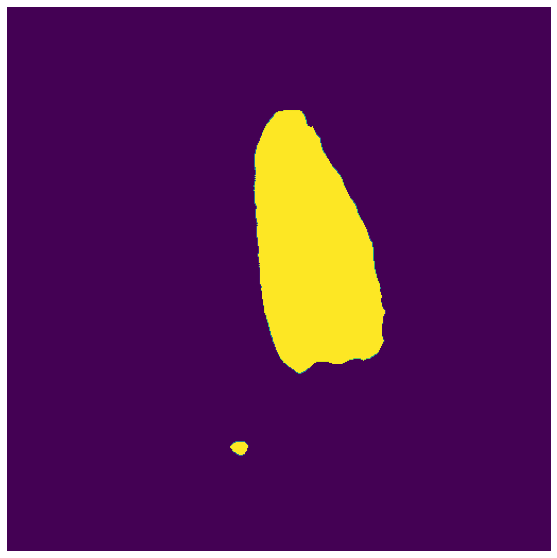

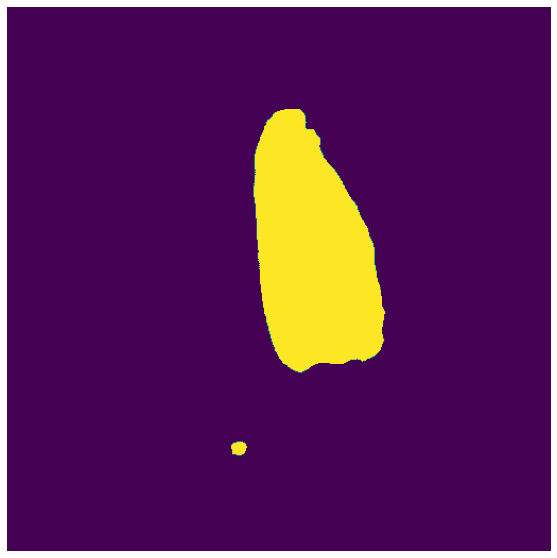

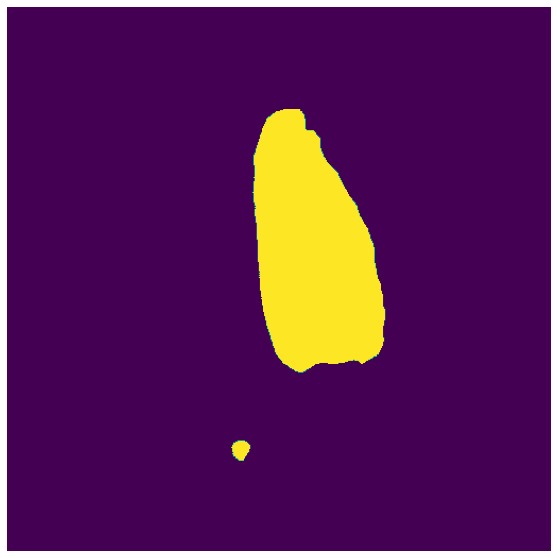

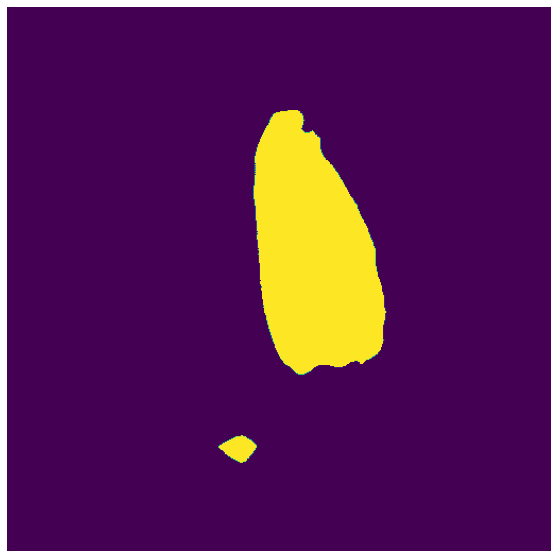

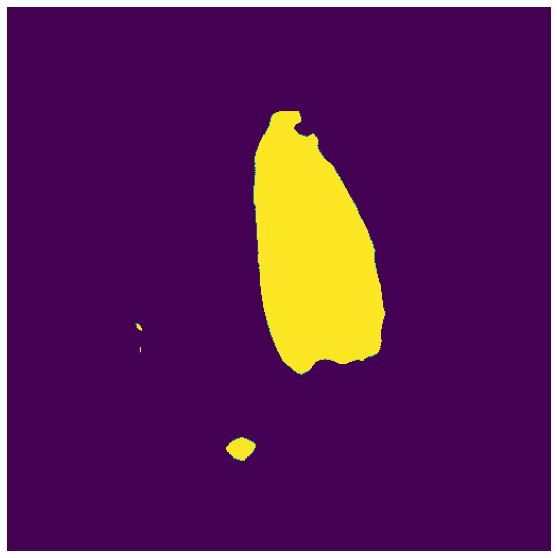

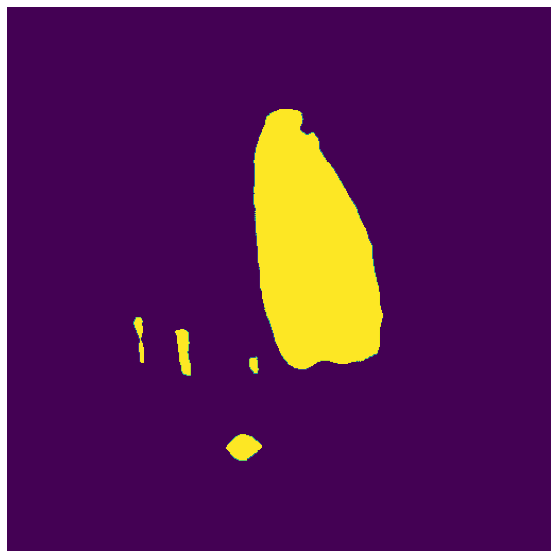

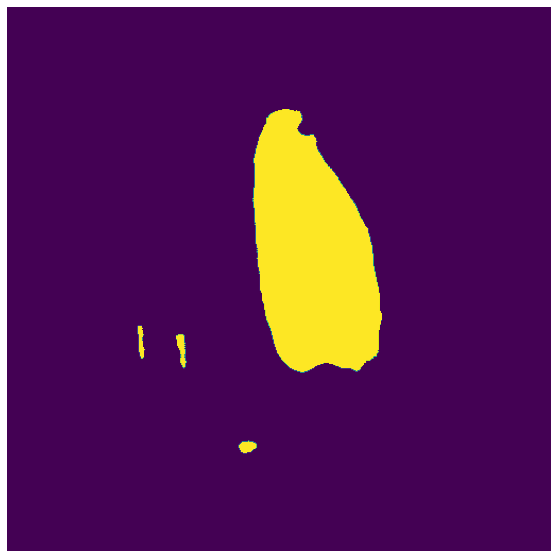

In [ ]:
predict_frames(frame_batches)

## Plot graph

### Plotting volume

In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/scripts/Echocardiography-Analysis-main/Mask\ Volume

/content/drive/MyDrive/ColabNotebooks/scripts/Echocardiography-Analysis-main/Mask Volume


In [ ]:
from maskvolume import *
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get_volume(file_name):
    mask_example= cv2.imread(file_name)
    vol, poly_points, minmaxline, midpointline, segments = get_mask_volume_quick(mask_example, K=20, is_binary_image = False)
    # print(vol)
    img = annotate_image(mask_example, poly_points, None, midpointline, segments)
    # plt.imshow(img)

    return vol

In [ ]:
mask_dir = os.fsencode(MASK_PATH)
vol_list = []
for file in os.listdir(MASK_PATH):
     filename = os.fsdecode(file)
     if filename.endswith(".png"):
        vol_list.append(get_volume(MASK_PATH + filename))
        continue
     else:
         continue

In [ ]:
x_axis = list(range(len(vol_list)))

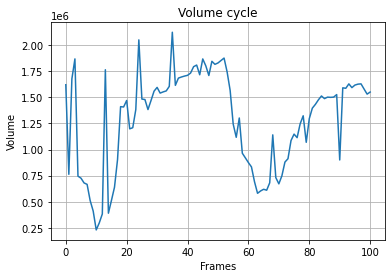

In [ ]:
import matplotlib.pyplot as plt

plt.title("Volume cycle")
plt.xlabel('Frames')
plt.ylabel('Volume')
plt.grid()
plt.plot(x_axis, vol_list)

In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

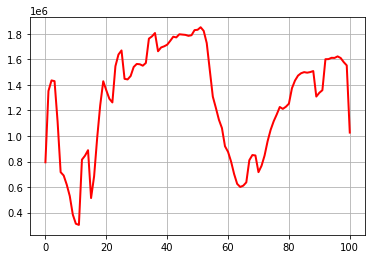

In [ ]:
plt.grid()
plt.plot(x_axis, smooth(vol_list,3), 'r-', lw=2)

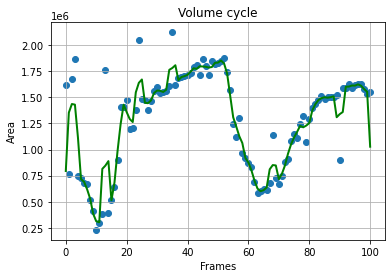

In [ ]:
plt.title("Volume cycle")
plt.xlabel('Frames')
plt.ylabel('Area')
plt.grid()
plt.scatter(x_axis, vol_list)
plt.plot(x_axis, smooth(vol_list,3), 'g-', lw=2)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


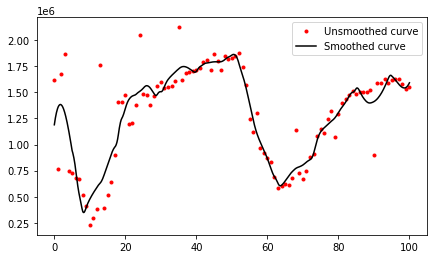

In [ ]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

x = np.array(x_axis)
y = np.array(vol_list) 

xx = np.linspace(x.min(),x.max(), 1000)

# interpolate + smooth
itp = interp1d(x,y, kind='linear')
window_size, poly_order = 101, 3
yy_sg_vol = savgol_filter(itp(xx), window_size, poly_order)


# or fit to a global function
def func(x, A, B, x0, sigma):
    return A+B*np.tanh((x-x0)/sigma)


fit, _ = curve_fit(func, x, y)
yy_fit = func(xx, *fit)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x, y, 'r.', label= 'Unsmoothed curve')
ax.plot(xx, yy_sg_vol, 'k', label= "Smoothed curve")
plt.legend(loc='best')

### plotting Area

In [ ]:
!pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def get_polypoints(file_name):
    mask_example= cv2.imread(file_name)
    vol, poly_points, minmaxline, midpointline, segments = get_mask_volume_quick(mask_example, K=20, is_binary_image = False)
    # print(vol)
    img = annotate_image(mask_example, poly_points, None, midpointline, segments)
    # plt.imshow(img)

    return poly_points

In [ ]:
example = get_polypoints("example_mask.png")
example = np.array(example)
example = example[:,0,:] # remove the extra dimension

In [ ]:
example.shape

(261, 2)

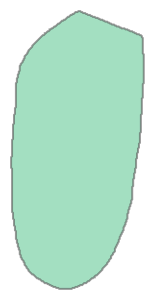

In [ ]:
from shapely.geometry import Polygon
pgon = Polygon(example)
pgon

In [ ]:
pgon.area

32029.5

In [ ]:
area_list = []
for file in os.listdir(MASK_PATH):
     filename = os.fsdecode(file)
     if filename.endswith(".png"):
        points = get_polypoints(MASK_PATH + filename)
        points = np.array(points)
        points = points[:, 0, :]
        polygon = Polygon(points)
        area_list.append(polygon.area)
        continue
     else:
         continue

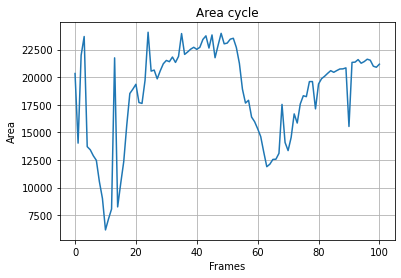

In [ ]:
plt.title("Area cycle")
plt.xlabel('Frames')
plt.ylabel('Area')
plt.grid()
plt.plot(x_axis, area_list)

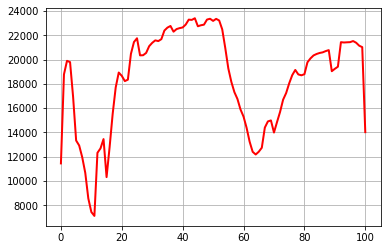

In [ ]:
plt.grid()
plt.plot(x_axis, smooth(area_list,3), 'r-', lw=2)

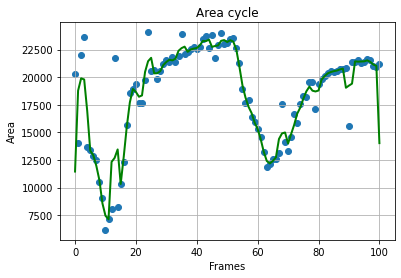

In [ ]:
plt.title("Area cycle")
plt.xlabel('Frames')
plt.ylabel('Area')
plt.grid()
plt.scatter(x_axis, area_list)
plt.plot(x_axis, smooth(area_list,3), 'g-', lw=2)

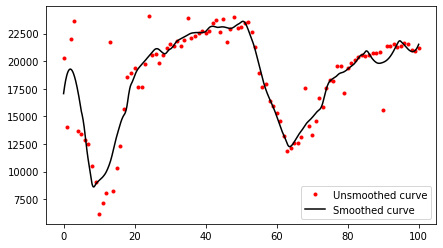

In [ ]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

x = np.array(x_axis)
y = np.array(area_list) 

xx = np.linspace(x.min(),x.max(), 1000)

# interpolate + smooth
itp = interp1d(x,y, kind='linear')
window_size, poly_order = 101, 3
yy_sg_area = savgol_filter(itp(xx), window_size, poly_order)


# or fit to a global function
def func(x, A, B, x0, sigma):
    return A+B*np.tanh((x-x0)/sigma)


fit, _ = curve_fit(func, x, y)
yy_fit = func(xx, *fit)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x, y, 'r.', label= 'Unsmoothed curve')
ax.plot(xx, yy_sg_area, 'k', label= "Smoothed curve")
plt.legend(loc='best')

### Plotting bad segmentation results 

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({'frame': x_axis,
                   'volume': vol_list,
                   'area': area_list})

In [ ]:
df.head()

,frame,volume,area
0,0,1.620181e+06,20325.5
1,1,7.626253e+05,14021.0
2,2,1.676784e+06,21978.5
3,3,1.867715e+06,23676.0
4,4,7.449306e+05,13702.5


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


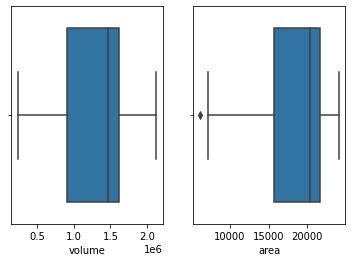

In [ ]:
import seaborn as sns

fig, ax =plt.subplots(1,2)
sns.boxplot(df['volume'], ax=ax[0])
sns.boxplot(x=df['area'], ax=ax[1])
fig.show()

In [ ]:
import scipy.signal 
m = df['volume'].shape[0]
b = yy_sg_vol

b = scipy.signal.resample(b,m)

b.shape

(101,)

In [ ]:
import scipy.signal 
df['delta volume'] = df['volume'] - scipy.signal.resample(yy_sg_vol,df['volume'].shape[0])
df['delta area'] = df['area'] - scipy.signal.resample(yy_sg_area,df['area'].shape[0])

df['delta volume'] = df['delta volume']
df['delta area'] = df['delta area']

In [ ]:
df.head()

,frame,volume,area,delta volume,delta area
0,0,1.620181e+06,20325.5,231806.792690,1073.563423
1,1,7.626253e+05,14021.0,-553721.654274,-4392.527787
2,2,1.676784e+06,21978.5,279980.326545,2503.797256
3,3,1.867715e+06,23676.0,578126.555269,5096.849835
4,4,7.449306e+05,13702.5,-409638.757470,-3748.601777


the worst frame predicted with volume

In [ ]:
from google.colab.patches import cv2_imshow
from PIL import Image

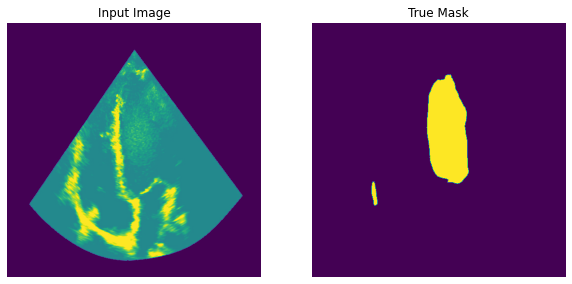


The worst mask predicted according to volume is at frame # 2


In [ ]:
worst_vol_mask = df.sort_values('delta volume')['frame'].iloc[0] + 1
worst_mask_path = MASK_PATH + str(worst_vol_mask) + ".png"
its_respective_image = IMAGE_PATH + "frame" + str(worst_vol_mask) + ".jpg"


image = tf.io.read_file(its_respective_image)
image = tf.image.decode_jpeg(image, channels=1)
image = tf.image.convert_image_dtype(image, tf.uint8)
mask = tf.io.read_file(worst_mask_path)
mask = tf.image.decode_png(mask, channels=1)


display([image, mask])

print("\nThe worst mask predicted according to volume is at frame #", worst_vol_mask)

worst frame pridected with area

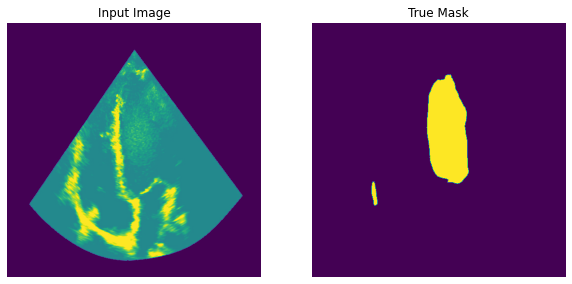


The worst mask predicted according to area is at frame # 2


In [ ]:
worst_area_mask = df.sort_values('delta area')['frame'].iloc[0] + 1
worst_mask_path = MASK_PATH + str(worst_area_mask) + ".png"
its_respective_image = IMAGE_PATH + "frame" + str(worst_area_mask) + ".jpg"


image = tf.io.read_file(its_respective_image)
image = tf.image.decode_jpeg(image, channels=1)
image = tf.image.convert_image_dtype(image, tf.uint8)
mask = tf.io.read_file(worst_mask_path)
mask = tf.image.decode_png(mask, channels=1)


display([image, mask])

print("\nThe worst mask predicted according to area is at frame #", worst_area_mask)